# Hi

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from pandas import date_range
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima, ARIMA, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from prophet import Prophet
from sklearn.linear_model import ElasticNet
import lightgbm as lgb
from lightgbm import LGBMRegressor

c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('train.csv')  
df.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [4]:
df.tail()

id        date  store_nbr                      family     sales  \
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [6]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [7]:
holiday = pd.read_csv('holidays_events.csv')
holiday.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [8]:
holiday['date'] = pd.to_datetime(holiday.date)
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [9]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [10]:
mdf = pd.merge(df, holiday, on='date', how='left')
mdf.head()

id       date  store_nbr      family  sales  onpromotion     type  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Holiday   
1   1 2013-01-01          1   BABY CARE    0.0            0  Holiday   
2   2 2013-01-01          1      BEAUTY    0.0            0  Holiday   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Holiday   
4   4 2013-01-01          1       BOOKS    0.0            0  Holiday   

     locale locale_name         description transferred  
0  National     Ecuador  Primer dia del ano       False  
1  National     Ecuador  Primer dia del ano       False  
2  National     Ecuador  Primer dia del ano       False  
3  National     Ecuador  Primer dia del ano       False  
4  National     Ecuador  Primer dia del ano       False

In [11]:
mdf['is_holiday'] = np.where(mdf['type'].isna(), 0, 1)
mdf.head()

id       date  store_nbr      family  sales  onpromotion     type  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Holiday   
1   1 2013-01-01          1   BABY CARE    0.0            0  Holiday   
2   2 2013-01-01          1      BEAUTY    0.0            0  Holiday   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Holiday   
4   4 2013-01-01          1       BOOKS    0.0            0  Holiday   

     locale locale_name         description transferred  is_holiday  
0  National     Ecuador  Primer dia del ano       False           1  
1  National     Ecuador  Primer dia del ano       False           1  
2  National     Ecuador  Primer dia del ano       False           1  
3  National     Ecuador  Primer dia del ano       False           1  
4  National     Ecuador  Primer dia del ano       False           1

In [12]:
df['store_nbr'].value_counts()

store_nbr
1     55572
10    55572
11    55572
12    55572
13    55572
14    55572
15    55572
16    55572
17    55572
18    55572
19    55572
2     55572
20    55572
21    55572
22    55572
23    55572
24    55572
25    55572
26    55572
27    55572
28    55572
29    55572
3     55572
30    55572
31    55572
32    55572
33    55572
34    55572
35    55572
36    55572
37    55572
38    55572
39    55572
4     55572
40    55572
41    55572
42    55572
43    55572
44    55572
45    55572
46    55572
47    55572
48    55572
49    55572
5     55572
50    55572
51    55572
52    55572
53    55572
54    55572
6     55572
7     55572
8     55572
9     55572
Name: count, dtype: int64

* I realized some unnecessary rows in the data while I was looking at the time serie of the stores one by one. If you select the stores from above, some of them have no sales at the beginning of 2013. You can see them, if you look at the those stores 20, 21, 22, 29, 36, 42, 52 and 53. I decided to remove those rows before the stores opened. In the following codes, we will get rid of them.

* from: https://www.kaggle.com/code/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide

In [13]:
print(df.shape)
df = df[~((df.store_nbr == 52) & (df.date < "2017-04-20"))]
df = df[~((df.store_nbr == 22) & (df.date < "2015-10-09"))]
df = df[~((df.store_nbr == 42) & (df.date < "2015-08-21"))]
df = df[~((df.store_nbr == 21) & (df.date < "2015-07-24"))]
df = df[~((df.store_nbr == 29) & (df.date < "2015-03-20"))]
df = df[~((df.store_nbr == 20) & (df.date < "2015-02-13"))]
df = df[~((df.store_nbr == 53) & (df.date < "2014-05-29"))]
df = df[~((df.store_nbr == 36) & (df.date < "2013-05-09"))]
df.shape

(3000888, 6)


(2780316, 6)

In [14]:
df['date'] = df.date.dt.to_period('D')
df = df.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    df.groupby(['family', 'date']).mean().unstack('family')
    .loc['2017',['sales', 'onpromotion']]
)

df.head()

id  sales  onpromotion
store_nbr family     date                                
1         AUTOMOTIVE 2013-01-01     0    0.0            0
                     2013-01-02  1782    2.0            0
                     2013-01-03  3564    3.0            0
                     2013-01-04  5346    3.0            0
                     2013-01-05  7128    5.0            0

In [15]:
family_sales = (
    df.groupby(['family', 'date']).mean().unstack('family')
    .loc[:,['sales', 'onpromotion']]
)

In [16]:
family_sales.head()

sales                                                      \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES BOOKS BREAD/BAKERY   
date                                                                        
2013-01-01   0.000000       0.0  0.043478    17.608696   0.0     3.925848   
2013-01-02   5.543478       0.0  4.500000  1567.217391   0.0   570.572152   
2013-01-03   3.500000       0.0  2.717391  1132.717391   0.0   401.227827   
2013-01-04   3.673913       0.0  2.891304  1177.543478   0.0   363.521065   
2013-01-05   7.434783       0.0  4.152174  1691.695652   0.0   486.255676   

                                                             ... onpromotion  \
family     CELEBRATION     CLEANING       DAIRY        DELI  ...   MAGAZINES   
date                                                         ...               
2013-01-01         0.0     4.043478    3.108696    1.545435  ...         0.0   
2013-01-02         0.0  1622.369565  508.282609  342.489130  ...         0.0   
2013-01-03         0.0  1215.065217  391.326087  242.879457  ...         0.0   
2013-01-04         0.0  1131.826087  394.521739  220.504543  ...         0.0   
2013-01-05         0.0  1524.521739  501.782609  298.585761  ...         0.0   

                                                                             \
family     MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                          
2013-01-01   0.0           0.0          0.0                     0.0     0.0   
2013-01-02   0.0           0.0          0.0                     0.0     0.0   
2013-01-03   0.0           0.0          0.0                     0.0     0.0   
2013-01-04   0.0           0.0          0.0                     0.0     0.0   
2013-01-05   0.0           0.0          0.0                     0.0     0.0   

                                                                      
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02            0.0     0.0                        0.0     0.0  
2013-01-03            0.0     0.0                        0.0     0.0  
2013-01-04            0.0     0.0                        0.0     0.0  
2013-01-05            0.0     0.0                        0.0     0.0  

[5 rows x 66 columns]

In [17]:
family_sales.to_csv('family_sales.csv')

C:\Users\ahmed\AppData\Local\Temp\ipykernel_34248\675341.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sales', y = 'family', data= a, palette ='viridis')


<Axes: xlabel='sales', ylabel='family'>

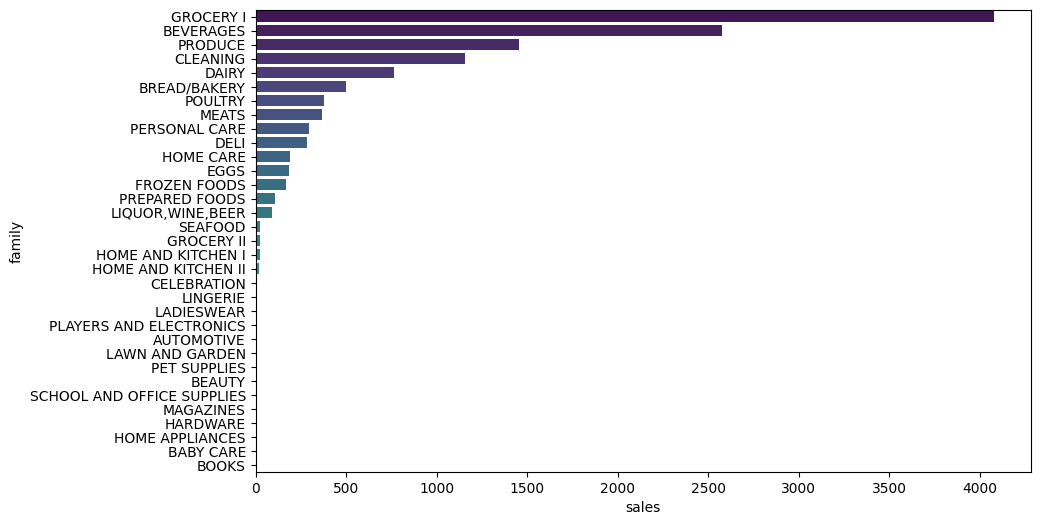

In [19]:
a = df.groupby('family').sales.mean().sort_values(ascending = False).reset_index()
plt.figure(figsize=(10,6))
sns.barplot(x='sales', y = 'family', data= a, palette ='viridis')

* The "GROCERY I" category likely includes essential, frequently purchased food items and household staples such as:

* Packaged foods (e.g., rice, pasta, canned goods)

* Non-perishable snacks

* Beverages (like juices and soft drinks)

* Baking supplies (e.g., flour, sugar)

* Pantry essentials (e.g., sauces, spices)

* Breakfast items (e.g., cereals, oats)

* In retail data, categories like "GROCERY I" and "GROCERY II" are often separated to distinguish between high-frequency essential products (GROCERY I) and less frequent purchases (GROCERY II). The exact contents can vary depending on the dataset's classification scheme.* 

In [2]:
stor = pd.read_csv('stores.csv')
train = pd.read_csv('train.csv')
merge_store = pd.merge(train, stor, how='left', on='store_nbr')
merge_store = merge_store.drop(columns=['cluster', 'type'])
merge_store.head()

id        date  store_nbr      family  sales  onpromotion   city      state
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha
1   1  2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha
2   2  2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha
3   3  2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha
4   4  2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha

plot sales per store, plot sales per state, plot popular family in a state and city

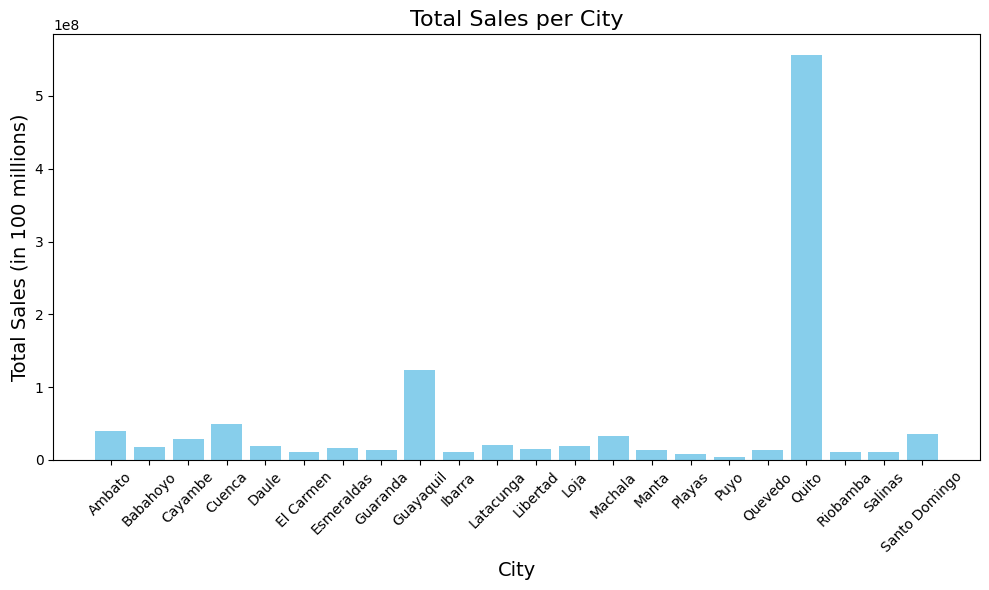

In [11]:
sales_per_city = merge_store.groupby('city')['sales'].sum().reset_index()

plt.figure(figsize=(10,6))
plt.bar(sales_per_city['city'], sales_per_city['sales'], color='skyblue')
plt.title('Total Sales per City', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Total Sales (in 100 millions)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

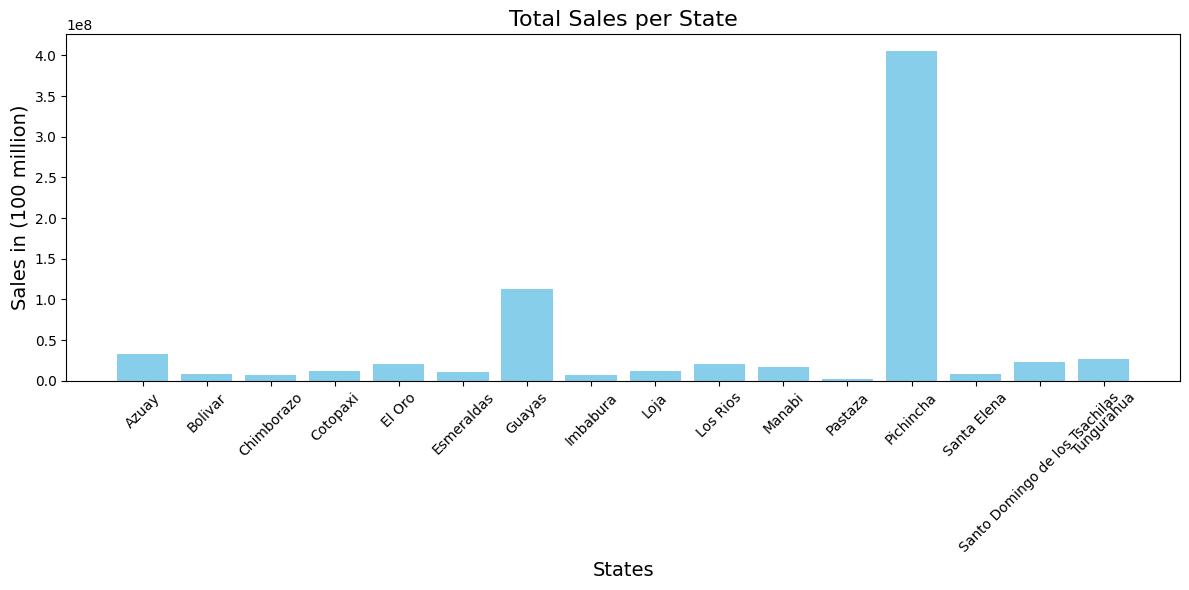

In [23]:
sales_per_state = merge_store.groupby('state')['sales'].sum().reset_index()

plt.figure(figsize=(12,6))
plt.bar(sales_per_state['state'], sales_per_state['sales'], color='skyblue')
plt.xlabel('States', fontsize=14)
plt.ylabel('Sales in (100 million)', fontsize=14)
plt.xticks(rotation=45)
plt.title('Total Sales per State', fontsize=16)
plt.tight_layout()
plt.show()

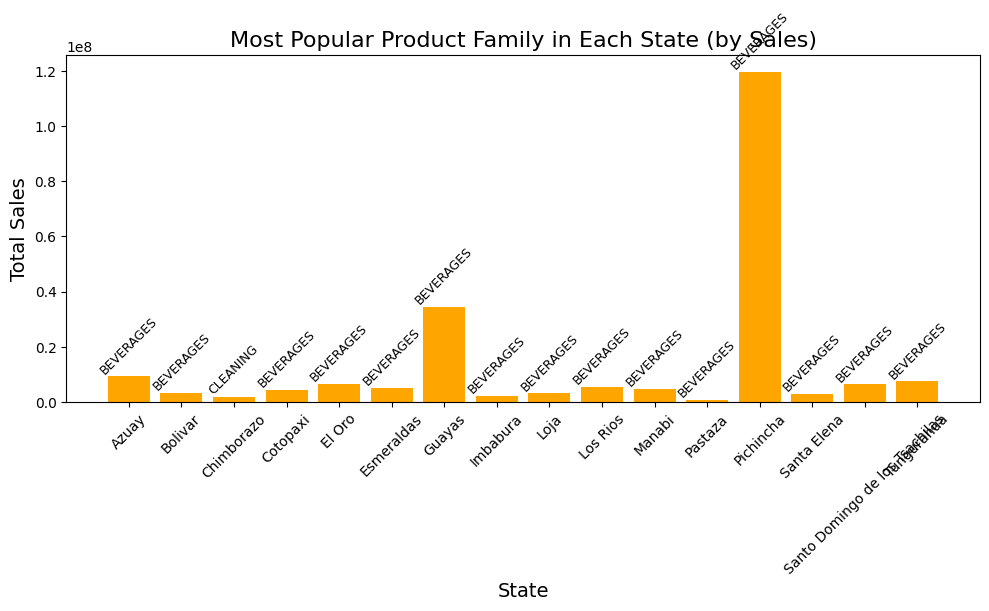

In [21]:
merge_store = merge_store[merge_store['family'] != 'GROCERY I']
merge_store = merge_store[merge_store['family'] != 'GROCERY II']

# Group by state and family, then sum the sales
grouped = merge_store.groupby(['state', 'family'])['sales'].sum().reset_index()

# For each state, find the family with the highest sales
idx = grouped.groupby('state')['sales'].idxmax()
popular_families = grouped.loc[idx].reset_index(drop=True)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(popular_families['state'], popular_families['sales'], color='orange')

plt.title('Most Popular Product Family in Each State (by Sales)', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Add labels for the family names on top of bars
for bar, label in zip(bars, popular_families['family']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, label, 
             ha='center', va='bottom', fontsize=9, rotation=45)

plt.show()


# Analysis of Top Categories

## Beverages

In [15]:
beverages_sales = family_sales.loc(axis=1)[:, 'BEVERAGES']
beverages_sales.head()

sales onpromotion
family        BEVERAGES   BEVERAGES
date                               
2013-01-01    17.608696         0.0
2013-01-02  1567.217391         0.0
2013-01-03  1132.717391         0.0
2013-01-04  1177.543478         0.0
2013-01-05  1691.695652         0.0

<Figure size 2000x400 with 0 Axes>

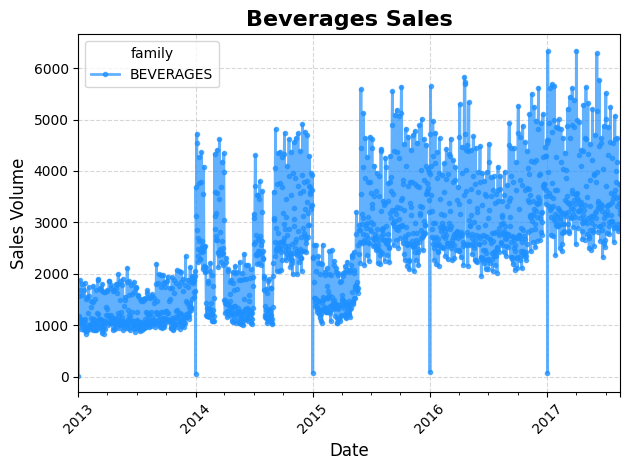

In [16]:
import matplotlib.pyplot as plt

# Set the figure size to be wider
plt.figure(figsize=(20, 4))

# Create the plot with improved styling
beverages_sales['sales'].plot(
    title='Beverages Sales Over Time', 
    color='#1E90FF',  # Dodger blue color
    linewidth=2,
    marker='o',  # Add markers
    markersize=3,
    alpha=0.7  # Slight transparency
)

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.title('Beverages Sales', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Tight layout to use space efficiently
plt.tight_layout()

# Show the plot
plt.show()

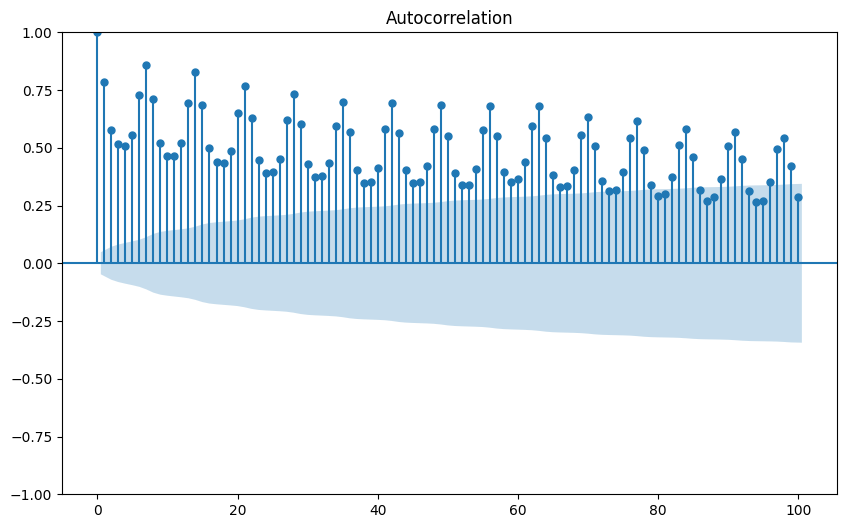

In [17]:
# plot auto-correlation (ACF)

fig, ax = plt.subplots(figsize = (10, 6))
plot_acf(beverages_sales['sales'], lags = 100, ax=ax)
plt.show()


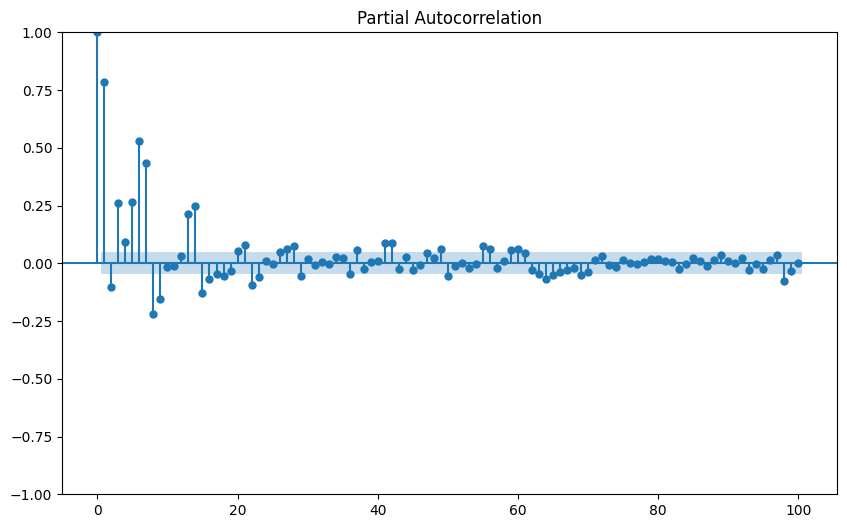

In [18]:
fig, ax = plt.subplots(figsize = (10, 6))
plot_pacf(beverages_sales['sales'], lags = 100, ax=ax)
plt.show()


In [19]:
print(beverages_sales.columns)


MultiIndex([(      'sales', 'BEVERAGES'),
            ('onpromotion', 'BEVERAGES')],
           names=[None, 'family'])


In [20]:
print(beverages_sales.index)


PeriodIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
             '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
             '2013-01-09', '2013-01-10',
             ...
             '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
             '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
             '2017-08-14', '2017-08-15'],
            dtype='period[D]', name='date', length=1684)


In [21]:
print(beverages_sales.reset_index().columns)

MultiIndex([(       'date',          ''),
            (      'sales', 'BEVERAGES'),
            ('onpromotion', 'BEVERAGES')],
           names=[None, 'family'])


### Moving Average('Trend')

<Axes: title={'center': 'Beverages Sales Trend'}, xlabel='date'>

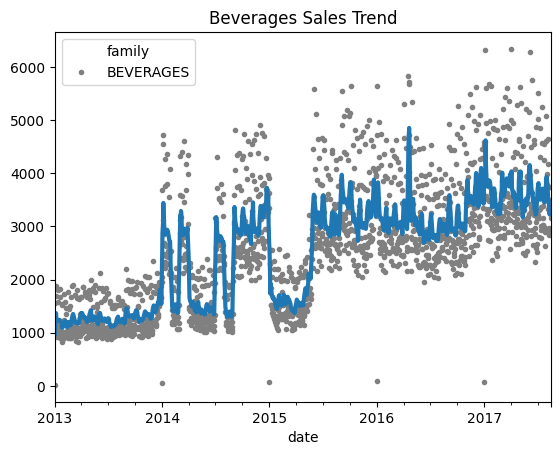

In [22]:
trend = beverages_sales['sales'].rolling(window=7, center=True, min_periods=4).mean() # calculate the trend
ax = beverages_sales['sales'].plot(style='.', color='0.5') # plot the data
trend.plot(ax=ax, linewidth=3, title='Beverages Sales Trend', legend=False) # plot the trend

### Forecast trend

In [23]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = beverages_sales[('sales', 'BEVERAGES')] # choose only the sales column, because model only expects one dimension

dp = DeterministicProcess(
    index= y.index, # dates from the training data, choose only the sales column, because model only expects one dimension
    constant = False,   # dummy feature for the bias (y_intercept)
    order = 3, # the time dummy (trend)
    drop = True # drop terms if necessary to avoid collinearity
)

X = dp.in_sample() # `in_sample` creates features for the dates given in the `index` argument

X_fore = dp.out_of_sample(steps=90) #  "Out of sample" refers to times outside of the observation period of the training data. 

In [24]:
X

trend  trend_squared   trend_cubed
date                                           
2013-01-01     1.0            1.0  1.000000e+00
2013-01-02     2.0            4.0  8.000000e+00
2013-01-03     3.0            9.0  2.700000e+01
2013-01-04     4.0           16.0  6.400000e+01
2013-01-05     5.0           25.0  1.250000e+02
...            ...            ...           ...
2017-08-11  1680.0      2822400.0  4.741632e+09
2017-08-12  1681.0      2825761.0  4.750104e+09
2017-08-13  1682.0      2829124.0  4.758587e+09
2017-08-14  1683.0      2832489.0  4.767079e+09
2017-08-15  1684.0      2835856.0  4.775582e+09

[1684 rows x 3 columns]

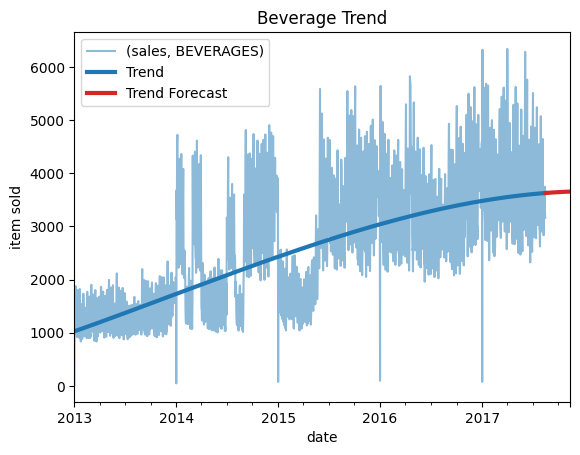

In [25]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)


ax = y.plot(alpha=0.5, title='Beverage Trend', ylabel = 'item sold') # plot the data
ax = y_pred.plot(ax=ax, linewidth=3, label='Trend', color='C0') # plot the trend
ax = y_fore.plot(ax=ax, linewidth=3, label='Trend Forecast', color='C3') # plot the trend forecast
ax.legend()



### Seasonality

C:\Users\ahmed\AppData\Local\Temp\ipykernel_20628\412866805.py:3: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  month_plot(beverages_sales['sales'].resample('M').mean(), ylabel = 'sales')


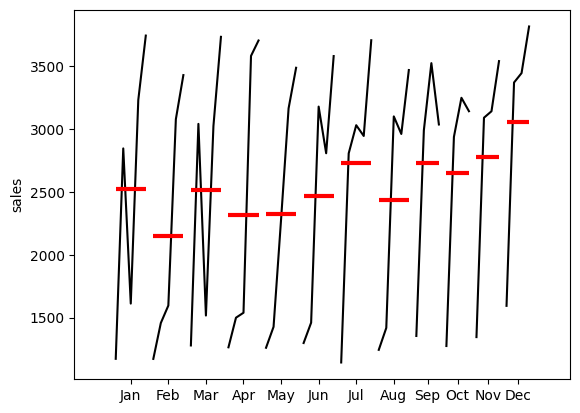

In [26]:
# Plot the monthly seasonality

month_plot(beverages_sales['sales'].resample('M').mean(), ylabel = 'sales')
plt.show()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_20628\3019437212.py:1: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  quarter_plot(beverages_sales['sales'].resample('Q').mean(), ylabel = 'sales')


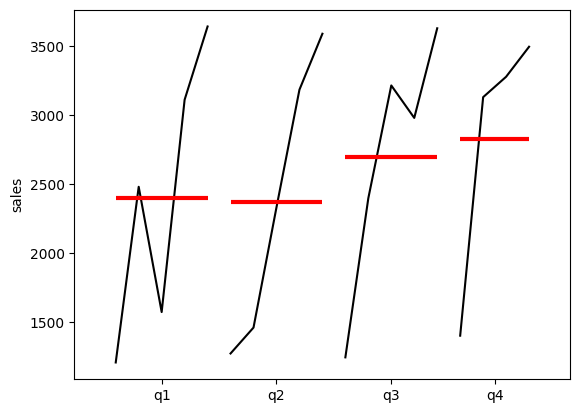

In [27]:
quarter_plot(beverages_sales['sales'].resample('Q').mean(), ylabel = 'sales')
plt.show()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_20628\512417244.py:4: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  weekly_sales = beverages_sales['sales'].resample('W').mean()


<Figure size 1200x600 with 0 Axes>

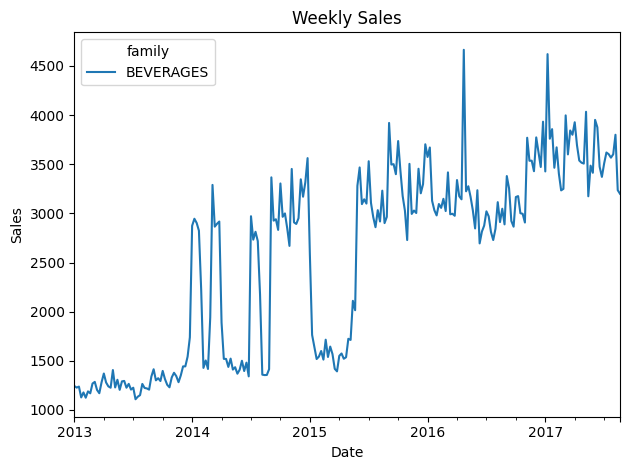

In [28]:
import matplotlib.pyplot as plt

# Resample to weekly mean
weekly_sales = beverages_sales['sales'].resample('W').mean()

# Create the plot
plt.figure(figsize=(12,6))
weekly_sales.plot()
plt.title('Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

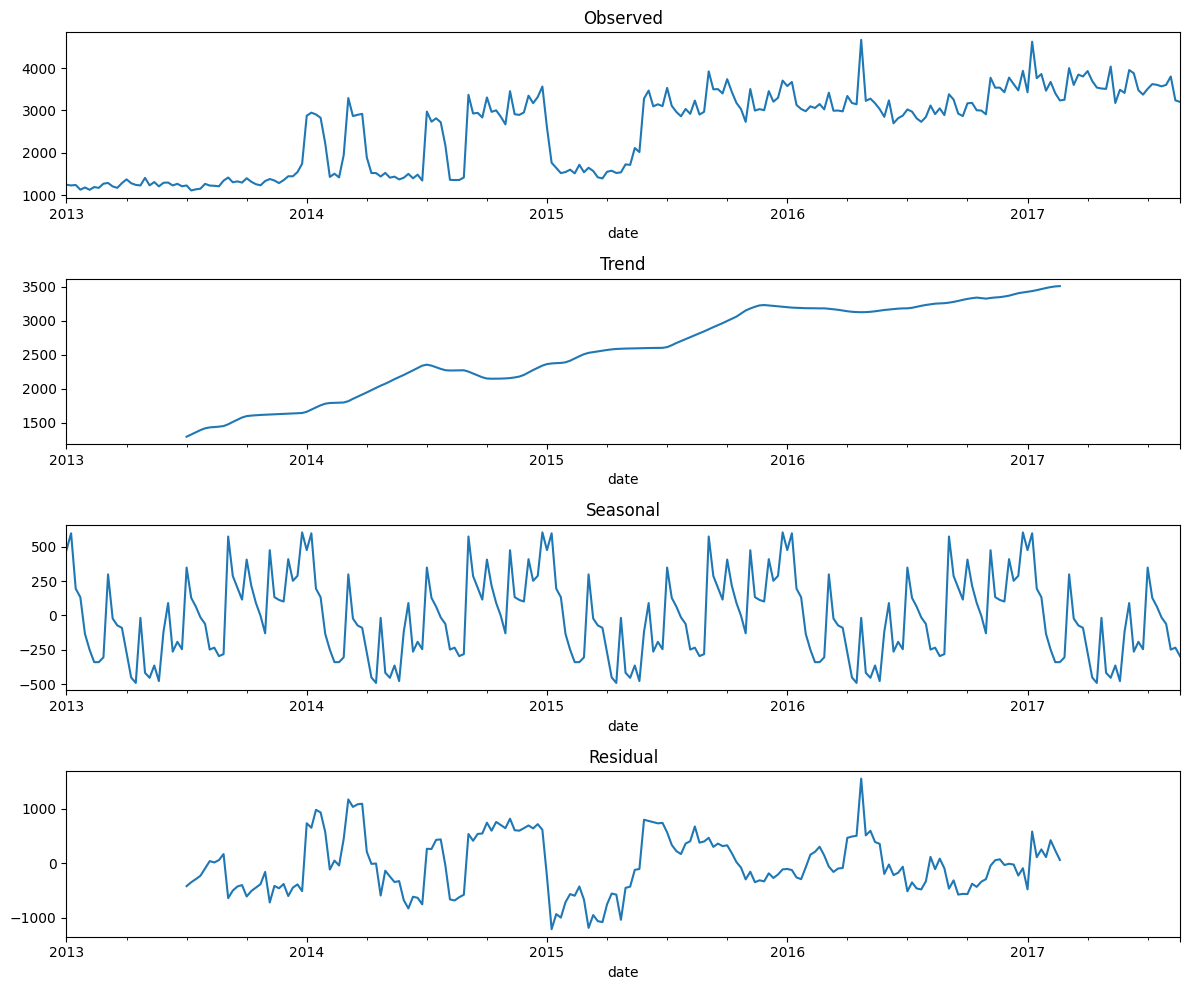

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(weekly_sales, period=52)  # 52 weeks in a year

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12,10))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

## Produce


In [30]:
produce_sales = family_sales.loc(axis=1)[:, 'PRODUCE']
produce_sales.head()

sales onpromotion
family     PRODUCE     PRODUCE
date                          
2013-01-01     0.0         0.0
2013-01-02     0.0         0.0
2013-01-03     0.0         0.0
2013-01-04     0.0         0.0
2013-01-05     0.0         0.0

<Figure size 2000x400 with 0 Axes>

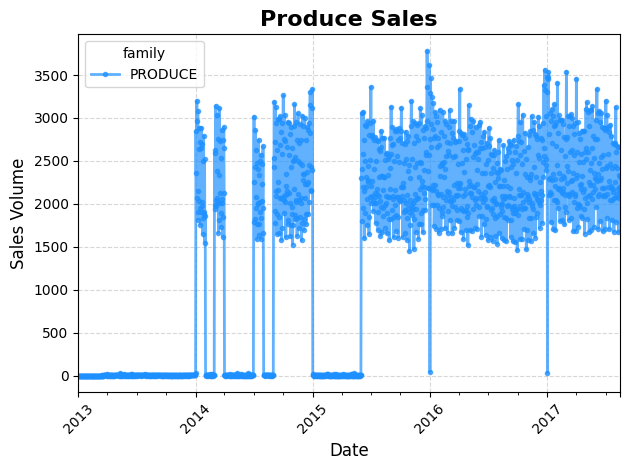

In [31]:
import matplotlib.pyplot as plt

# Set the figure size to be wider
plt.figure(figsize=(20, 4))

# Create the plot with improved styling
produce_sales['sales'].plot(
    title='Produce Sales Over Time', 
    color='#1E90FF',  # Dodger blue color
    linewidth=2,
    marker='o',  # Add markers
    markersize=3,
    alpha=0.7  # Slight transparency
)

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.title('Produce Sales', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Tight layout to use space efficiently
plt.tight_layout()

# Show the plot
plt.show()

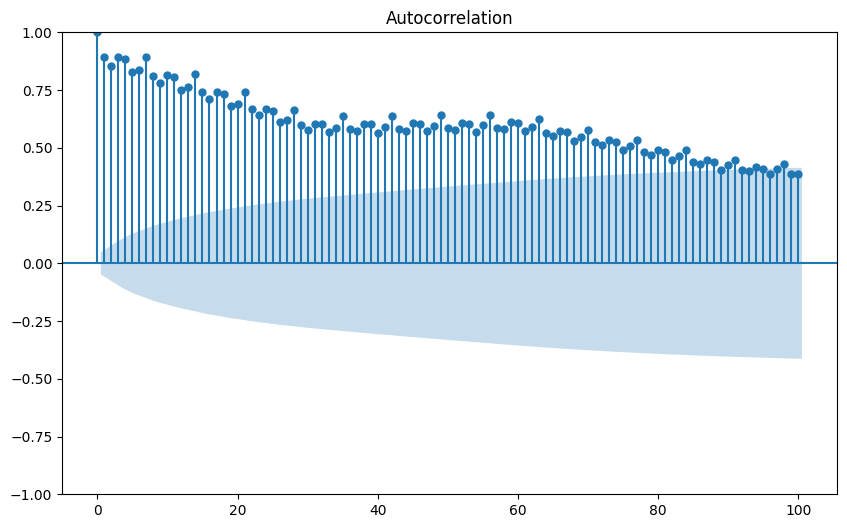

In [32]:
# plot auto-correlation (ACF)

fig, ax = plt.subplots(figsize = (10, 6))
plot_acf(produce_sales['sales'], lags = 100, ax=ax)
plt.show()


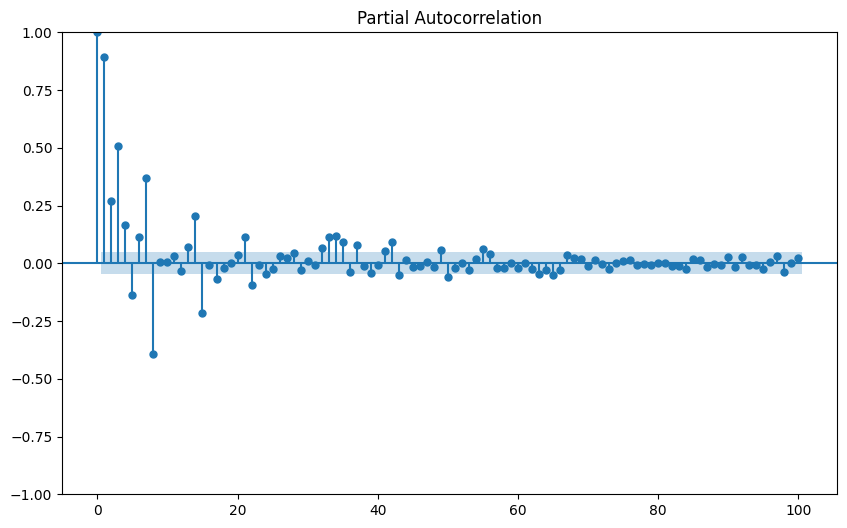

In [33]:
fig, ax = plt.subplots(figsize = (10, 6))
plot_pacf(produce_sales['sales'], lags = 100, ax=ax)
plt.show()


In [34]:
print(produce_sales.columns)


MultiIndex([(      'sales', 'PRODUCE'),
            ('onpromotion', 'PRODUCE')],
           names=[None, 'family'])


In [35]:
print(produce_sales.index)


PeriodIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
             '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
             '2013-01-09', '2013-01-10',
             ...
             '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
             '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
             '2017-08-14', '2017-08-15'],
            dtype='period[D]', name='date', length=1684)


In [36]:
print(produce_sales.reset_index().columns)

MultiIndex([(       'date',        ''),
            (      'sales', 'PRODUCE'),
            ('onpromotion', 'PRODUCE')],
           names=[None, 'family'])


### Trend


<Axes: title={'center': 'Produce Sales Trend'}, xlabel='date'>

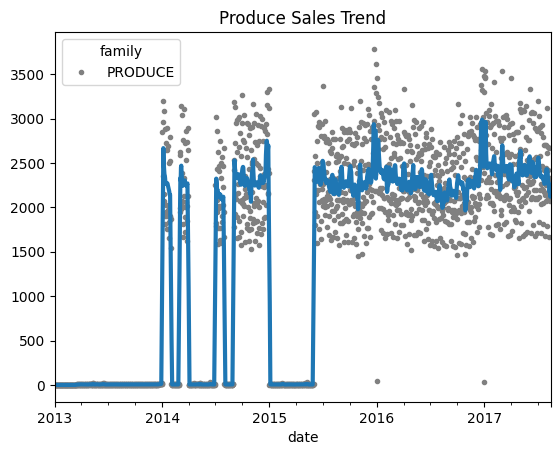

In [37]:
trend = produce_sales['sales'].rolling(window=7, center=True, min_periods=4).mean() # calculate the trend
ax = produce_sales['sales'].plot(style='.', color='0.5') # plot the data
trend.plot(ax=ax, linewidth=3, title='Produce Sales Trend', legend=False) # plot the trend

In [38]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = produce_sales[('sales', 'PRODUCE')] # choose only the sales column, because model only expects one dimension

dp = DeterministicProcess(
    index= y.index, # dates from the training data, choose only the sales column, because model only expects one dimension
    constant = False,   # dummy feature for the bias (y_intercept)
    order = 2, # the time dummy (trend) # if u make the order too high the trend will fall
    drop = True # drop terms if necessary to avoid collinearity
)

X = dp.in_sample() # `in_sample` creates features for the dates given in the `index` argument

X_fore = dp.out_of_sample(steps=90) #  "Out of sample" refers to times outside of the observation period of the training data. 

In [39]:
X

trend  trend_squared
date                             
2013-01-01     1.0            1.0
2013-01-02     2.0            4.0
2013-01-03     3.0            9.0
2013-01-04     4.0           16.0
2013-01-05     5.0           25.0
...            ...            ...
2017-08-11  1680.0      2822400.0
2017-08-12  1681.0      2825761.0
2017-08-13  1682.0      2829124.0
2017-08-14  1683.0      2832489.0
2017-08-15  1684.0      2835856.0

[1684 rows x 2 columns]

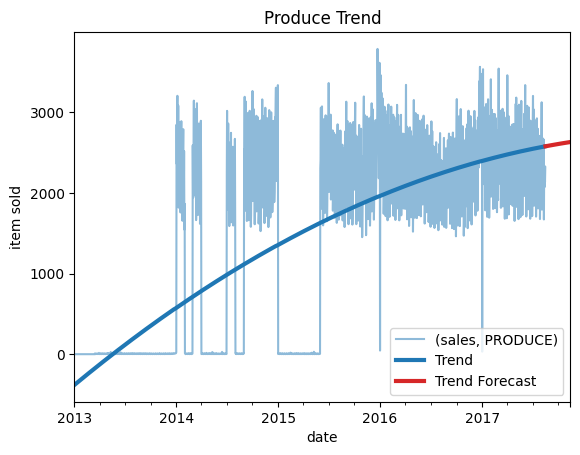

In [40]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)


ax = y.plot(alpha=0.5, title='Produce Trend', ylabel = 'item sold') # plot the data
ax = y_pred.plot(ax=ax, linewidth=3, label='Trend', color='C0') # plot the trend
ax = y_fore.plot(ax=ax, linewidth=3, label='Trend Forecast', color='C3') # plot the trend forecast
ax.legend()



### Seasonality

C:\Users\ahmed\AppData\Local\Temp\ipykernel_20628\1107100198.py:3: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  month_plot(produce_sales['sales'].resample('M').mean(), ylabel = 'sales')


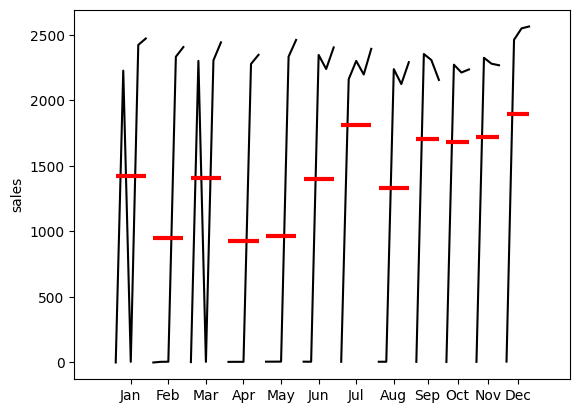

In [41]:
# Plot the monthly seasonality

month_plot(produce_sales['sales'].resample('M').mean(), ylabel = 'sales')
plt.show()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_20628\3570960343.py:1: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  quarter_plot(produce_sales['sales'].resample('Q').mean(), ylabel = 'sales')


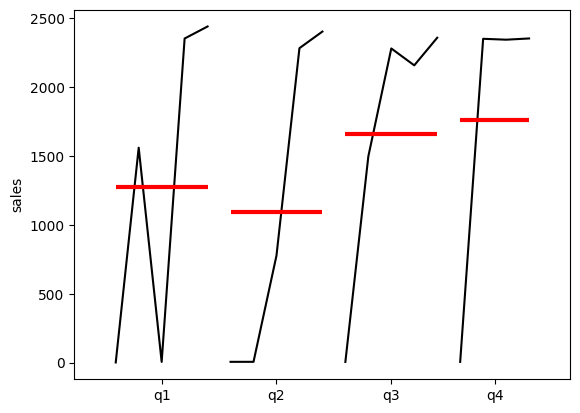

In [42]:
quarter_plot(produce_sales['sales'].resample('Q').mean(), ylabel = 'sales')
plt.show()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_20628\1159680694.py:4: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  weekly_sales = produce_sales['sales'].resample('W').mean()


<Figure size 1200x400 with 0 Axes>

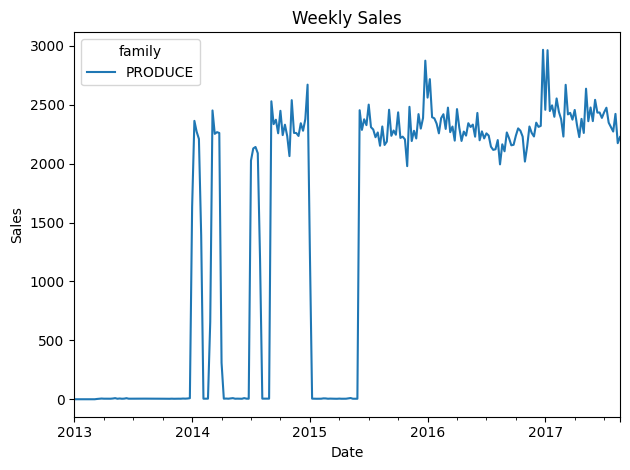

In [43]:
import matplotlib.pyplot as plt

# Resample to weekly mean
weekly_sales = produce_sales['sales'].resample('W').mean()

# Create the plot
plt.figure(figsize=(12,4))
weekly_sales.plot()
plt.title('Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

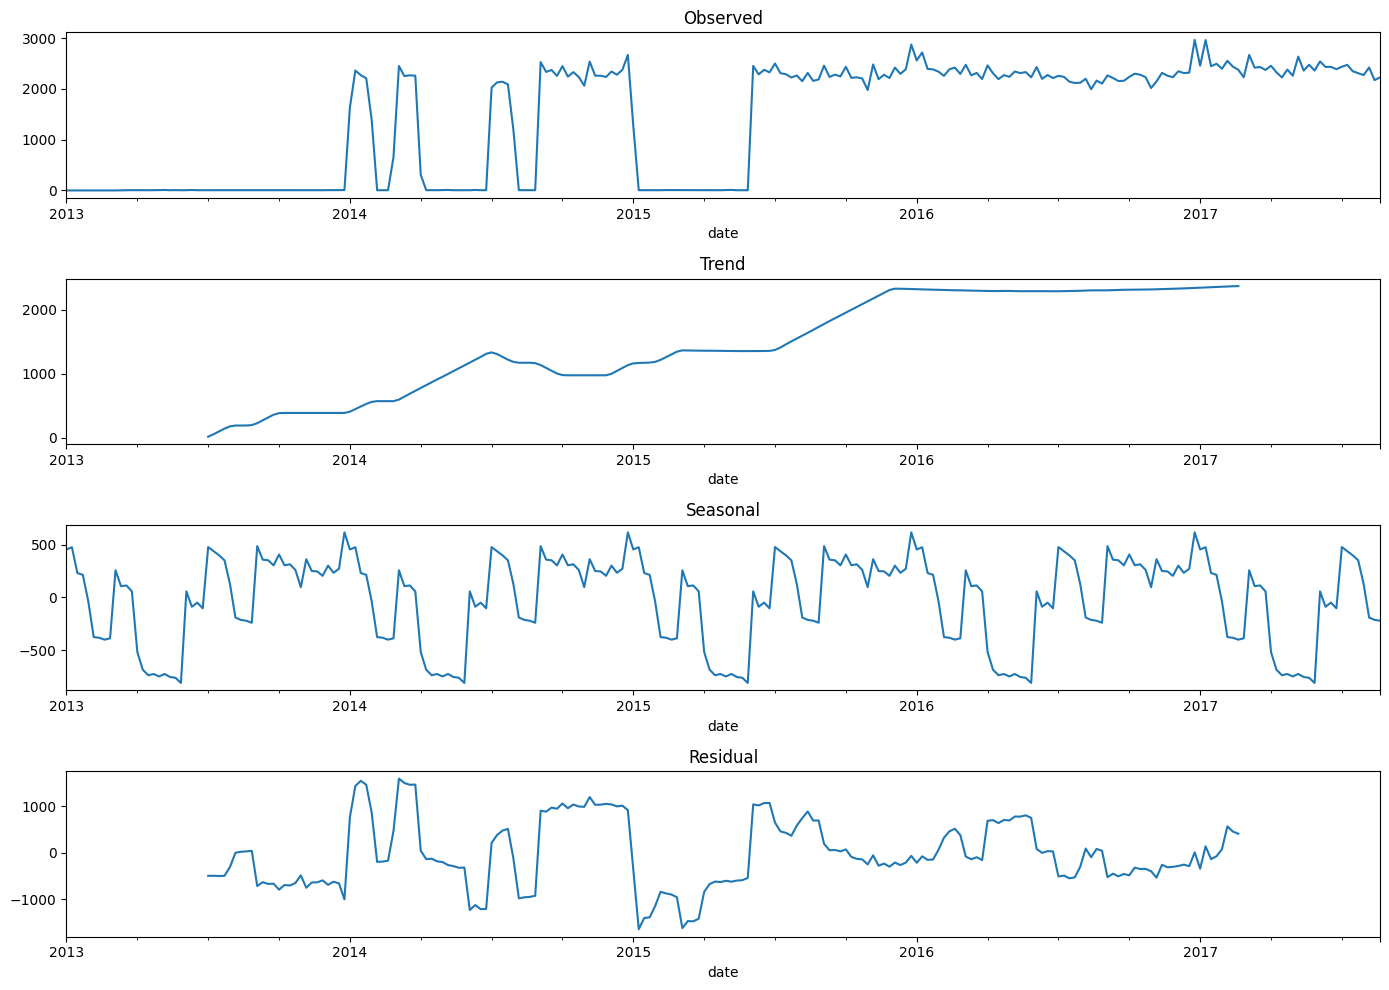

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure proper timestamp index
sales = produce_sales['sales'].copy()
# sales.index = pd.to_datetime(sales.index)
sales = sales.to_timestamp()
# Resample to weekly mean
weekly_sales = sales.resample('W').mean()

# Perform seasonal decomposition
decomposition = seasonal_decompose(weekly_sales, period=52)

# Plot full decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14,10))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

# Modeling

In [24]:
# You'll add fit and predict methods to this minimal class

class boostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None

In [25]:
def fit(self, X_1, X_2, y):
    self.model_1.fit(X_1, y)
    # make predictions with self.model_1
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns
    )
    # compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze()

    #  fit self.model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns

    self.y_fit = y_fit
    self.y_resid = y_resid

# Add method to class
boostedHybrid.fit = fit

In [26]:
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index = X_1.index, columns=self.y_columns
    )

    y_pred = y_pred.stack().squeeze() # wide too long

    y_pred += self.model_2.predict(X_2) # add self.model_2 predictions to y_pred

    return y_pred.unstack() # long to wide

boostedHybrid.predict = predict



In [3]:
family_sales = pd.read_csv(
    'family_sales.csv',
    index_col=0,          # Set 'date' as index (first column)
    parse_dates=True,     # Parse 'date' into datetime
    header=[0, 1]         # Two header rows for MultiIndex columns
)

latest_family_sales = family_sales[family_sales.index.year >= 2016]

latest_family_sales.columns = pd.MultiIndex.from_tuples(
    family_sales.columns,
    names=['metric', 'family']  # Optional: name the column levels
)

# Display the DataFrame (now matches your original structure)
display(latest_family_sales.head(3))

metric          sales                                                      \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES BOOKS BREAD/BAKERY   
date                                                                        
2016-01-01   0.075472  0.000000  0.245283    96.301887   0.0    12.848151   
2016-01-02  11.792453  0.169811  7.207547  4726.603774   0.0   631.407057   
2016-01-03  12.471698  0.320755  8.000000  5644.849057   0.0   771.799623   

metric                                                        ... onpromotion  \
family     CELEBRATION     CLEANING        DAIRY        DELI  ...   MAGAZINES   
date                                                          ...               
2016-01-01    0.245283    13.849057    19.490566    5.569453  ...         0.0   
2016-01-02   19.622642  1761.830189  1038.471698  426.252302  ...         0.0   
2016-01-03   13.811321  1953.660377  1290.018868  478.595604  ...         0.0   

metric                                                                   \
family         MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                      
2016-01-01  0.773585      0.018868     0.000000                     0.0   
2016-01-02  0.169811      0.943396     0.056604                     0.0   
2016-01-03  0.301887      0.849057     0.037736                     0.0   

metric                                                                    \
family       POULTRY PREPARED FOODS   PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                       
2016-01-01  0.509434       0.018868  0.000000                   0.000000   
2016-01-02  0.169811       0.018868  0.075472                   0.000000   
2016-01-03  0.245283       0.000000  0.264151                   0.056604   

metric                
family       SEAFOOD  
date                  
2016-01-01  0.037736  
2016-01-02  0.754717  
2016-01-03  0.000000  

[3 rows x 66 columns]

(A deterministic process, by the way, is a technical term for a time series that is non-random or completely determined, like the const and trend series are. Features derived from the time index will generally be deterministic.)

In [28]:
y = latest_family_sales.loc[:, 'sales']

dp = DeterministicProcess(index=y.index, order=1) # trend (order 1 means linear)
X_1 = dp.in_sample() # future steps
 
# X_2 are xgboost features

X_2 = latest_family_sales.drop('sales', axis=1).stack() # onpromotion

# Label encoding for column 'family' 
le = LabelEncoder()
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

X_2['day'] = X_2.index.day

C:\Users\ahmed\AppData\Local\Temp\ipykernel_32584\2087420315.py:8: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

C:\Users\ahmed\AppData\Local\Temp\ipykernel_32584\2087420315.py:8: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.



In [29]:
X_2

metric      family  onpromotion  day
date                                
2016-01-01       0     0.000000    1
2016-01-01       1     0.000000    1
2016-01-01       2     0.000000    1
2016-01-01       3     0.018868    1
2016-01-01       4     0.000000    1
...            ...          ...  ...
2017-08-15      28     0.111111   15
2017-08-15      29     0.166667   15
2017-08-15      30    58.685185   15
2017-08-15      31     2.740741   15
2017-08-15      32     0.000000   15

[19536 rows x 3 columns]

Create the hybrid model by initializing a BoostedHybrid class with LinearRegression() and XGBRegressor() instances.

C:\Users\ahmed\AppData\Local\Temp\ipykernel_32584\958733473.py:21: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.

C:\Users\ahmed\AppData\Local\Temp\ipykernel_32584\958733473.py:22: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.



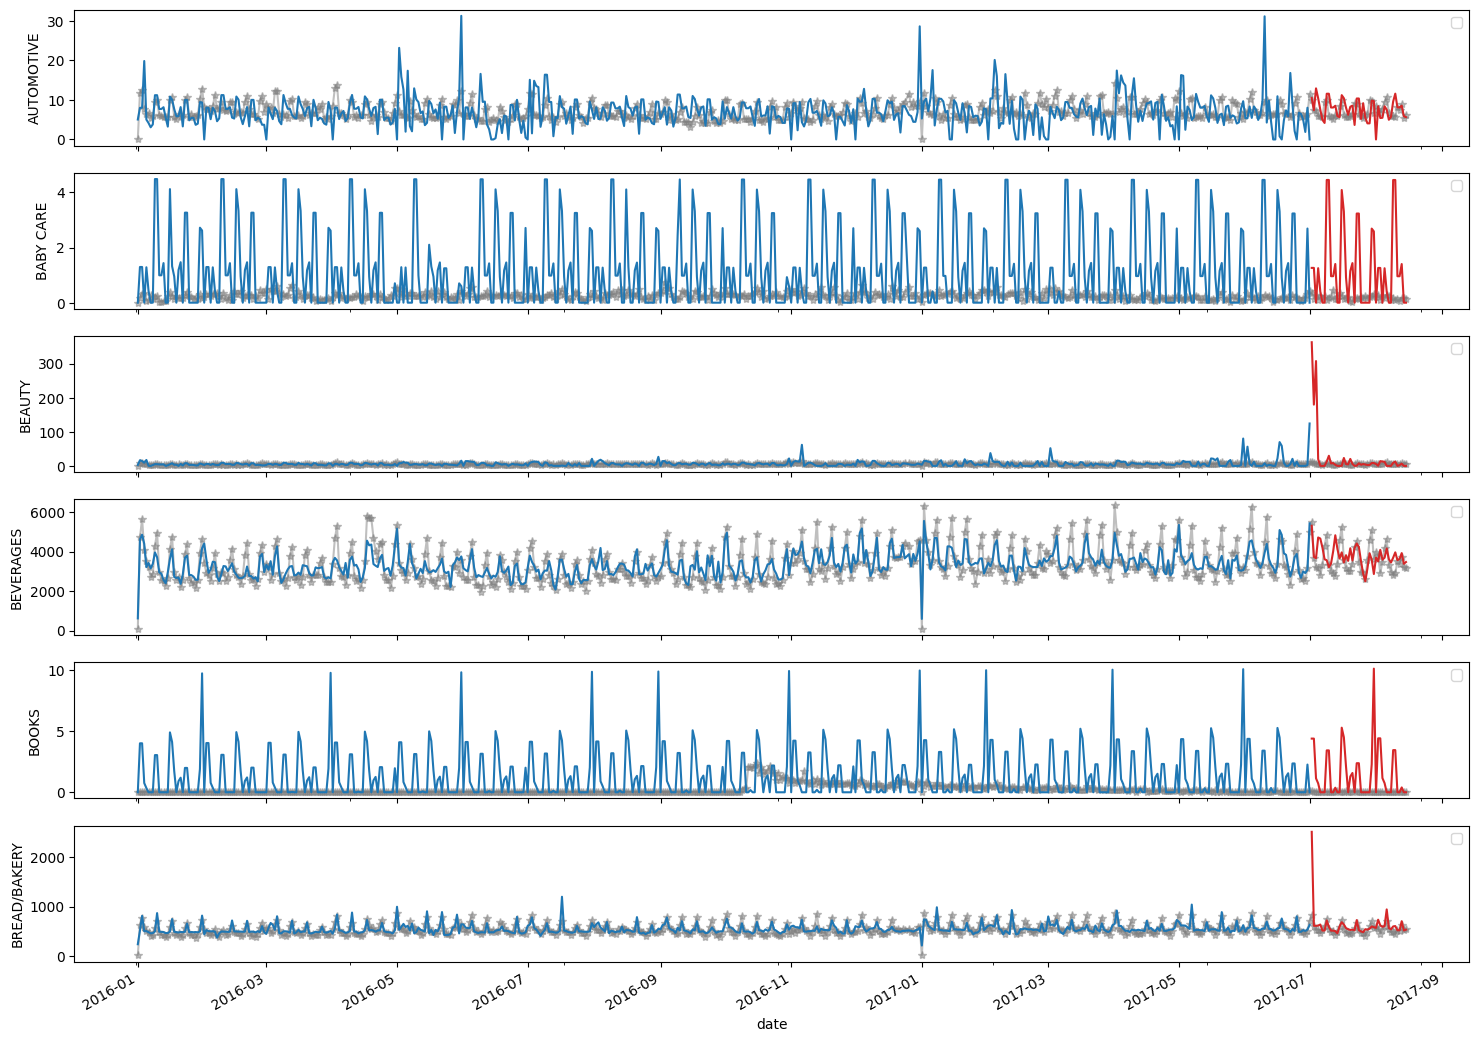

In [30]:
model = boostedHybrid(
    model_1 = LinearRegression(),
    model_2 = XGBRegressor(),
)

# valid are the test set of predictions set, x1 is trend(steps) x2 is external factors

y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[:"2017-07-01"], X_1["2017-07-02":]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(18,14), alpha=0.5, style='-*', color='grey'
)

_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C3',  ax=axs)

for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

In [31]:
y_pred.head()

family      AUTOMOTIVE  BABY CARE      BEAUTY    BEVERAGES     BOOKS  \
date                                                                   
2017-07-02   10.484630   1.261519  362.854188  5308.115477  4.378880   
2017-07-03    7.399862   1.261459  179.802641  3735.166634  4.379583   
2017-07-04   12.929787   0.000000  307.657587  3668.513998  1.135988   
2017-07-05   10.440804   1.251071   19.843774  4716.531741  0.726954   
2017-07-06    7.525227   0.401391    0.000000  4664.544255  0.000000   

family      BREAD/BAKERY  CELEBRATION     CLEANING        DAIRY        DELI  \
date                                                                          
2017-07-02   2511.123764    19.340028  2103.701688  1335.716861  384.573348   
2017-07-03    609.748838    19.339990  1612.288343  1178.342668  377.570071   
2017-07-04    609.001536    13.525566  2168.484250  1219.161788  371.229842   
2017-07-05    614.356965    13.115791  2182.920698   596.482556  354.011775   
2017-07-06    635.359461     9.896188  1446.822584   991.495437  255.137560   

family      ...  MAGAZINES       MEATS  PERSONAL CARE  PET SUPPLIES  \
date        ...                                                       
2017-07-02  ...   9.336116  395.290670     468.693244     16.733138   
2017-07-03  ...   9.337237  372.836535     441.448053     19.936578   
2017-07-04  ...   6.094059  367.220025     421.566402     14.933300   
2017-07-05  ...   5.685444  387.464356     355.877151      4.294624   
2017-07-06  ...   5.478251  339.073605     356.942240      8.957215   

family      PLAYERS AND ELECTRONICS     POULTRY  PREPARED FOODS      PRODUCE  \
date                                                                           
2017-07-02                28.585227  432.129139      126.786554  2904.185004   
2017-07-03                17.249344  436.030422      126.772093  2598.123780   
2017-07-04                23.590239  423.113545      113.468397  2709.449335   
2017-07-05                19.194916  399.427362      106.549636  3108.326816   
2017-07-06                12.418911  394.786417       99.200290  1929.942853   

family      SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                               
2017-07-02                   10.525908  26.481192  
2017-07-03                   10.531468  26.476580  
2017-07-04                    3.417844  16.956215  
2017-07-05                    0.000000  25.688352  
2017-07-06                    5.761023  27.873575  

[5 rows x 33 columns]

### Error Metric Evaluation

y_pred - y_test(y_valid)

In [32]:
mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_valid, y_pred)

print(f'Mean Absolute Error is {mae:.2f}')
print(f'Root Mean Squared Error is {rmse:.2f}')
print(f'Mean Absolute Percentage Error is {mape:.2f}')

Mean Absolute Error is 89.36
Root Mean Squared Error is 253.56
Mean Absolute Percentage Error is 60877923370615.97


For a category like BABY CARE where y_valid = 0.000001 and y_pred = 0.1:
MAPE = |(0.1 - 0.000001)/0.000001| * 100 = 9,999,900%

Even one such case dominates the average.

error rate is pretty high lets try to scale the data and do it. Because too many columns, and sales data are in different scales, some are 0.5 and some are 5000. 

In [33]:
y_valid_clipped = y_valid.replace(0, 1e-10)  # Avoid division by zero
mape = mean_absolute_percentage_error(y_valid_clipped, y_pred)
print(f'Improved Mean Absolute Percentage Error is {mape:.2f}')

Improved Mean Absolute Percentage Error is 135176146.55


### Try to improve the model

In [34]:
# add more time based features to the xgboost (X_2)

X_2['day_of_week'] = X_2.index.dayofweek
X_2['month'] = X_2.index.month

X_2.head()

metric      family  onpromotion  day  day_of_week  month
date                                                    
2016-01-01       0     0.000000    1            4      1
2016-01-01       1     0.000000    1            4      1
2016-01-01       2     0.000000    1            4      1
2016-01-01       3     0.018868    1            4      1
2016-01-01       4     0.000000    1            4      1

C:\Users\ahmed\AppData\Local\Temp\ipykernel_32584\3339292256.py:28: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.

C:\Users\ahmed\AppData\Local\Temp\ipykernel_32584\3339292256.py:29: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.



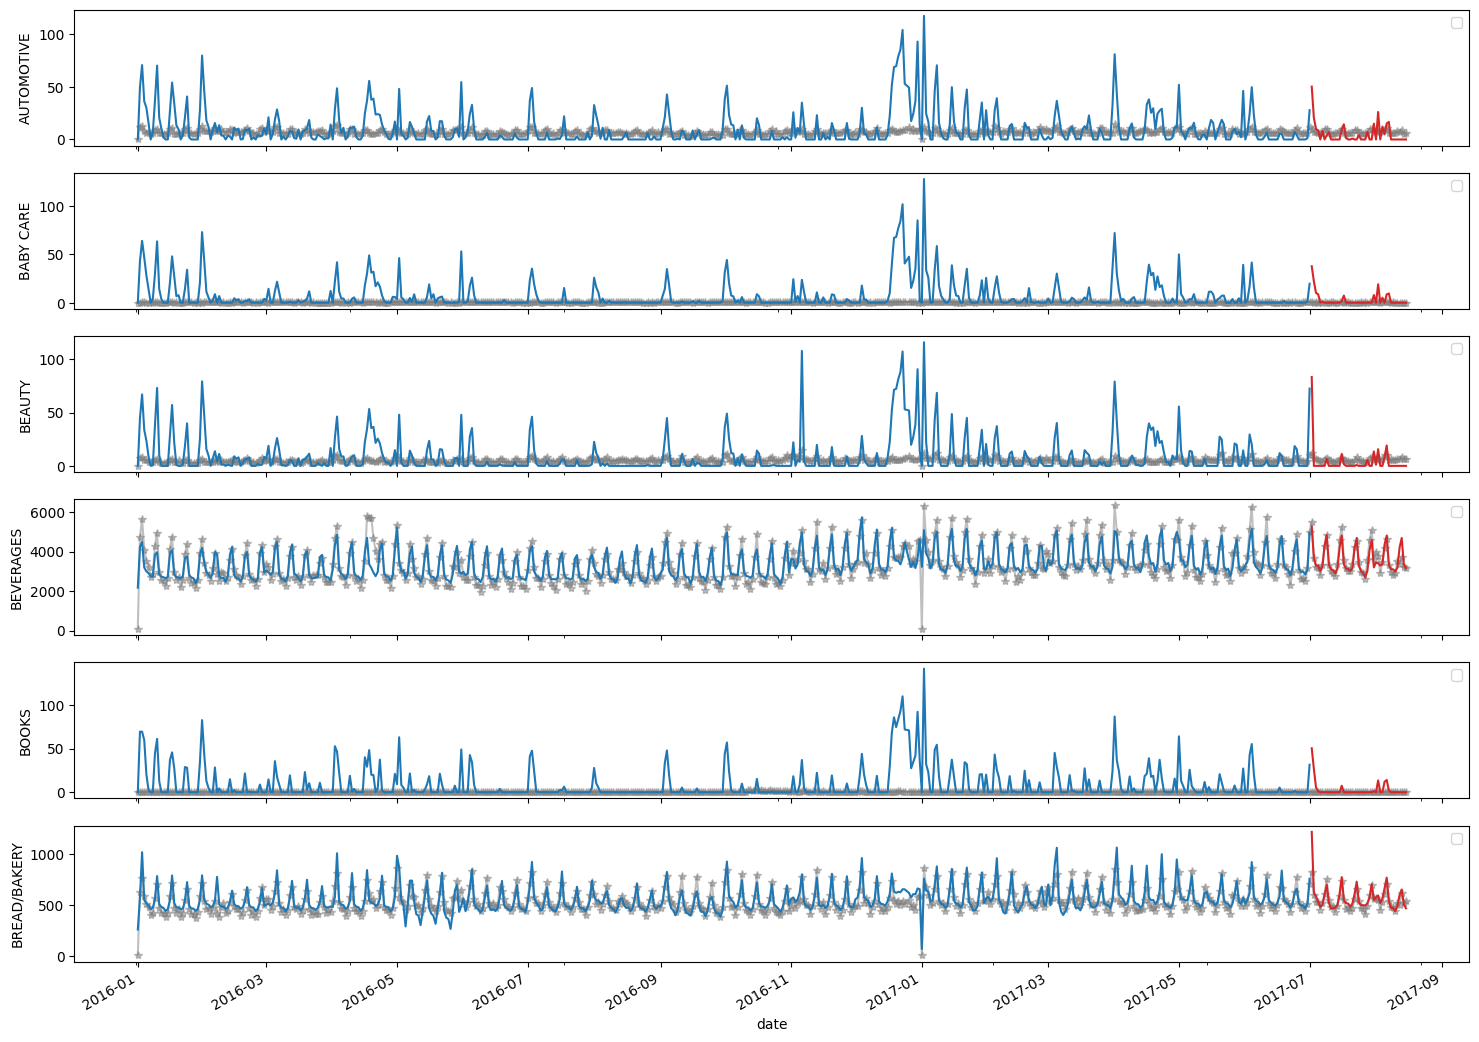

In [35]:
new_model = boostedHybrid(
    model_1 = ElasticNet(alpha=0.1, l1_ratio=0.5), # to capture complex trends better
    model_2 = XGBRegressor(
        n_estimators=200, 
        max_depth=5, #prevent overfitting
        learning_rate=0.05, # slower, more stable
        subsample=0.8,  # Stochastic boosting
        colsample_bytree=0.7, # feature randomness
        gamma=0.1 # Regulariztion
    ),
)

# valid are the test set of predictions set, x1 is trend(steps) x2 is external factors

y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[:"2017-07-01"], X_1["2017-07-02":]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

new_model.fit(X1_train, X2_train, y_train)
y_fit = new_model.predict(X1_train, X2_train).clip(0.0)
y_pred = new_model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(18,14), alpha=0.5, style='-*', color='grey'
)

_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C3',  ax=axs)

for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

In [36]:
mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_valid, y_pred)

print(f'Mean Absolute Error is {mae:.2f}')
print(f'Root Mean Squared Error is {rmse:.2f}')
print(f'Mean Absolute Percentage Error is {mape:.2f}')

Mean Absolute Error is 43.45
Root Mean Squared Error is 99.08
Mean Absolute Percentage Error is 82849960539215.80


In [37]:
y_valid_clipped = y_valid.replace(0, 1e-10)  # Avoid division by zero
mape = mean_absolute_percentage_error(y_valid_clipped, y_pred)
print(f'Improved Mean Absolute Percentage Error is {mape:.2f}')

Improved Mean Absolute Percentage Error is 183963870.92


In [40]:
msle = mean_squared_log_error(y_valid, y_pred)
rmsle = np.sqrt(msle)
print(f'The RMSLE is {rmsle}')

The RMSLE is 1.1563610646757896


The graph may not look different but the error metrics do suggest that the model has improved

### Time to forecast

In [ ]:
testset = pd.read_csv('test.csv')
testset.head()
test_sales.shape

(16, 33)

In [ ]:
test_sales= (
    testset.groupby(['family', 'date']).mean().unstack('family')
    .loc[:,['onpromotion']]
)
test_sales.head()

onpromotion                                                    \
family      AUTOMOTIVE BABY CARE    BEAUTY  BEVERAGES BOOKS BREAD/BAKERY   
date                                                                       
2017-08-16    0.000000  0.000000  2.000000  31.592593   0.0    13.944444   
2017-08-17    0.000000  0.000000  0.851852  18.759259   0.0     8.148148   
2017-08-18    0.000000  0.000000  0.888889  18.777778   0.0     9.166667   
2017-08-19    0.000000  0.018519  1.000000  20.203704   0.0     9.314815   
2017-08-20    0.018519  0.000000  0.944444  20.574074   0.0    32.000000   

                                                         ...            \
family     CELEBRATION   CLEANING      DAIRY       DELI  ... MAGAZINES   
date                                                     ...             
2017-08-16    0.000000  26.888889  84.759259  18.055556  ...       0.0   
2017-08-17    0.018519  13.425926  12.277778   6.462963  ...       0.0   
2017-08-18    0.000000  14.518519  16.037037  55.222222  ...       0.0   
2017-08-19    0.037037  16.055556  16.611111   7.611111  ...       0.0   
2017-08-20    0.000000  15.814815  16.425926   7.870370  ...       0.0   

                                                                          \
family          MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                       
2017-08-16   0.018519     18.000000     0.000000                0.148148   
2017-08-17   8.981481      8.740741     0.018519                0.074074   
2017-08-18  22.796296      9.907407     0.000000                0.148148   
2017-08-19   0.037037     10.722222     0.000000                0.203704   
2017-08-20   0.000000     11.203704     0.000000                0.129630   

                                                                             \
family        POULTRY PREPARED FOODS     PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                          
2017-08-16   0.185185       0.148148  223.314815                  13.592593   
2017-08-17   0.092593       0.018519    2.074074                   2.629630   
2017-08-18  25.240741       0.370370    2.611111                   2.407407   
2017-08-19   0.092593       0.000000    2.833333                   2.740741   
2017-08-20   0.129630       0.000000    2.814815                   2.814815   

                      
family       SEAFOOD  
date                  
2017-08-16  0.000000  
2017-08-17  0.000000  
2017-08-18  2.592593  
2017-08-19  0.777778  
2017-08-20  0.000000  

[5 rows x 33 columns]

In [ ]:
test_sales.index = pd.to_datetime(test_sales.index)

In [ ]:
dpdp = DeterministicProcess(index=test_sales.index, order=1) # get the trend
test_X1 = dpdp.in_sample() # future steps

test_X2 = test_sales.stack() # it has the promotional values
test_X2 = test_X2.reset_index('family') 
test_X2['family'] = le.fit_transform(test_X2['family'])

test_X2['day'] = test_X2.index.day
test_X2['day_of_week'] = test_X2.index.dayofweek
test_X2['month'] = test_X2.index.month
test_X2.head()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_21688\1635531824.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  test_X2 = test_sales.stack() # it has the promotional values


family  onpromotion  day  day_of_week  month
date                                                    
2017-08-16       0     0.000000   16            2      8
2017-08-16       1     0.000000   16            2      8
2017-08-16       2     2.000000   16            2      8
2017-08-16       3    31.592593   16            2      8
2017-08-16       4     0.000000   16            2      8

C:\Users\ahmed\AppData\Local\Temp\ipykernel_21688\3617460775.py:15: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C0', ax=axs)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_21688\3617460775.py:16: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C3',  ax=axs)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_21688\3617460775.py:17: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_fore.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C5',  ax=axs)


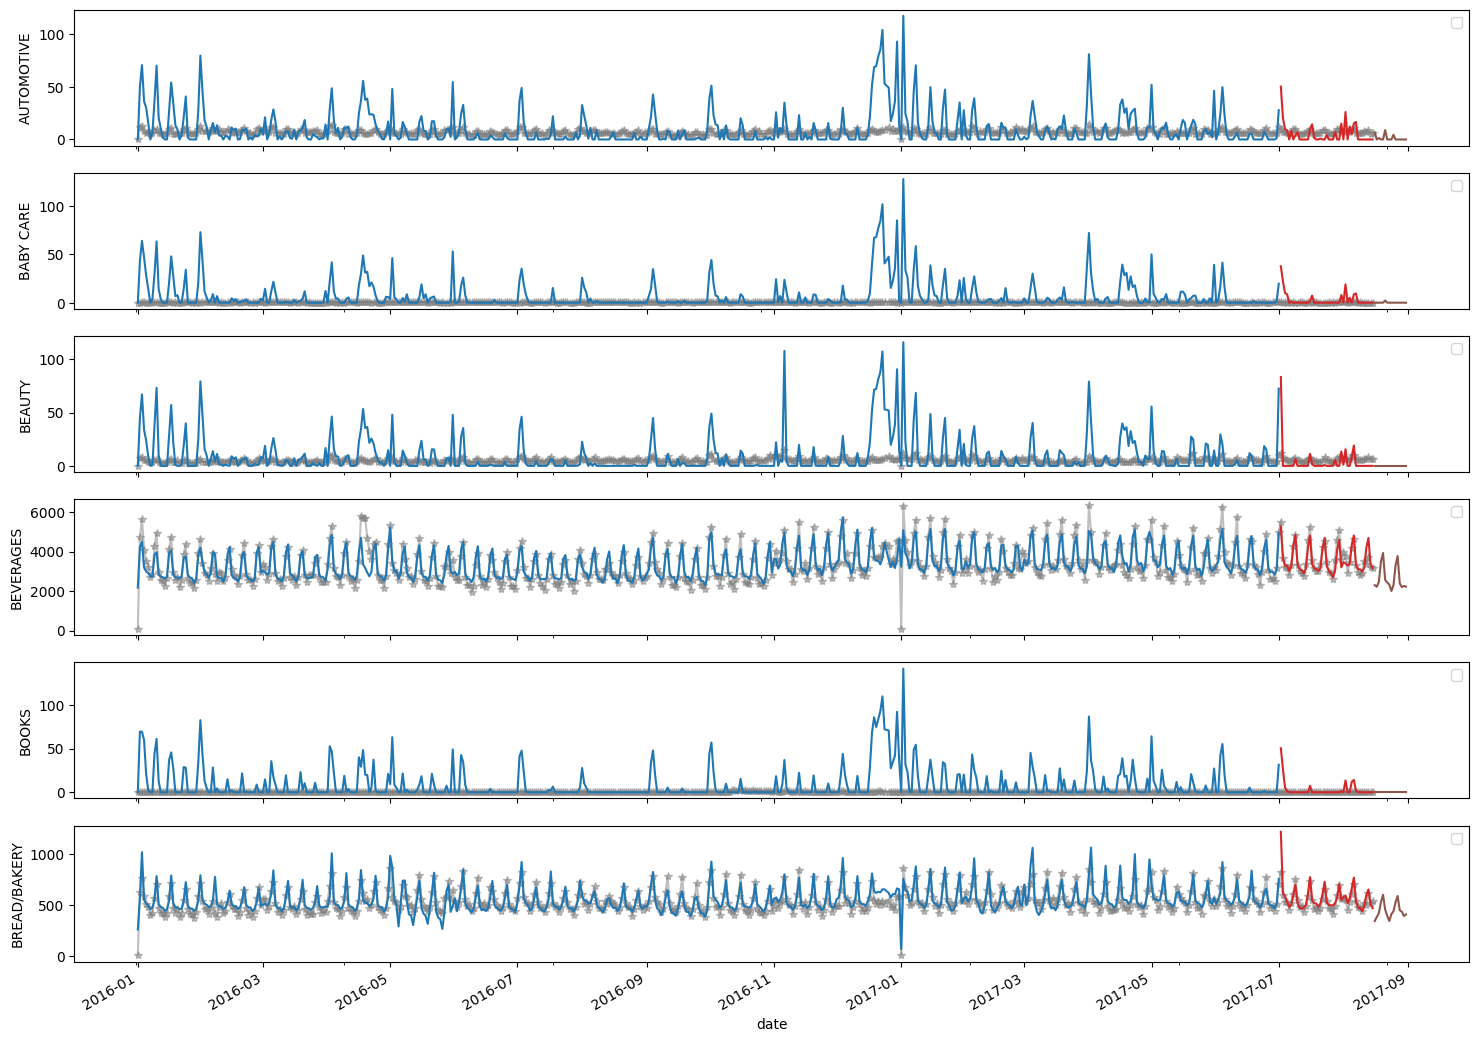

In [ ]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[:"2017-07-01"], X_1["2017-07-02":]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

new_model.fit(X1_train, X2_train, y_train)
y_fit = new_model.predict(X1_train, X2_train).clip(0.0)
y_pred = new_model.predict(X1_valid, X2_valid).clip(0.0)
y_fore = new_model.predict(test_X1, test_X2).clip(0.0)

families = y.columns[0:6] # printing for families 6 to 12
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(18,14), alpha=0.5, style='-*', color='grey'
)

_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C3',  ax=axs)
_ = y_fore.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C5',  ax=axs)

for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

C:\Users\ahmed\AppData\Local\Temp\ipykernel_21688\107567211.py:15: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C0', ax=axs)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_21688\107567211.py:16: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C3',  ax=axs)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_21688\107567211.py:17: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_fore.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C5',  ax=axs)


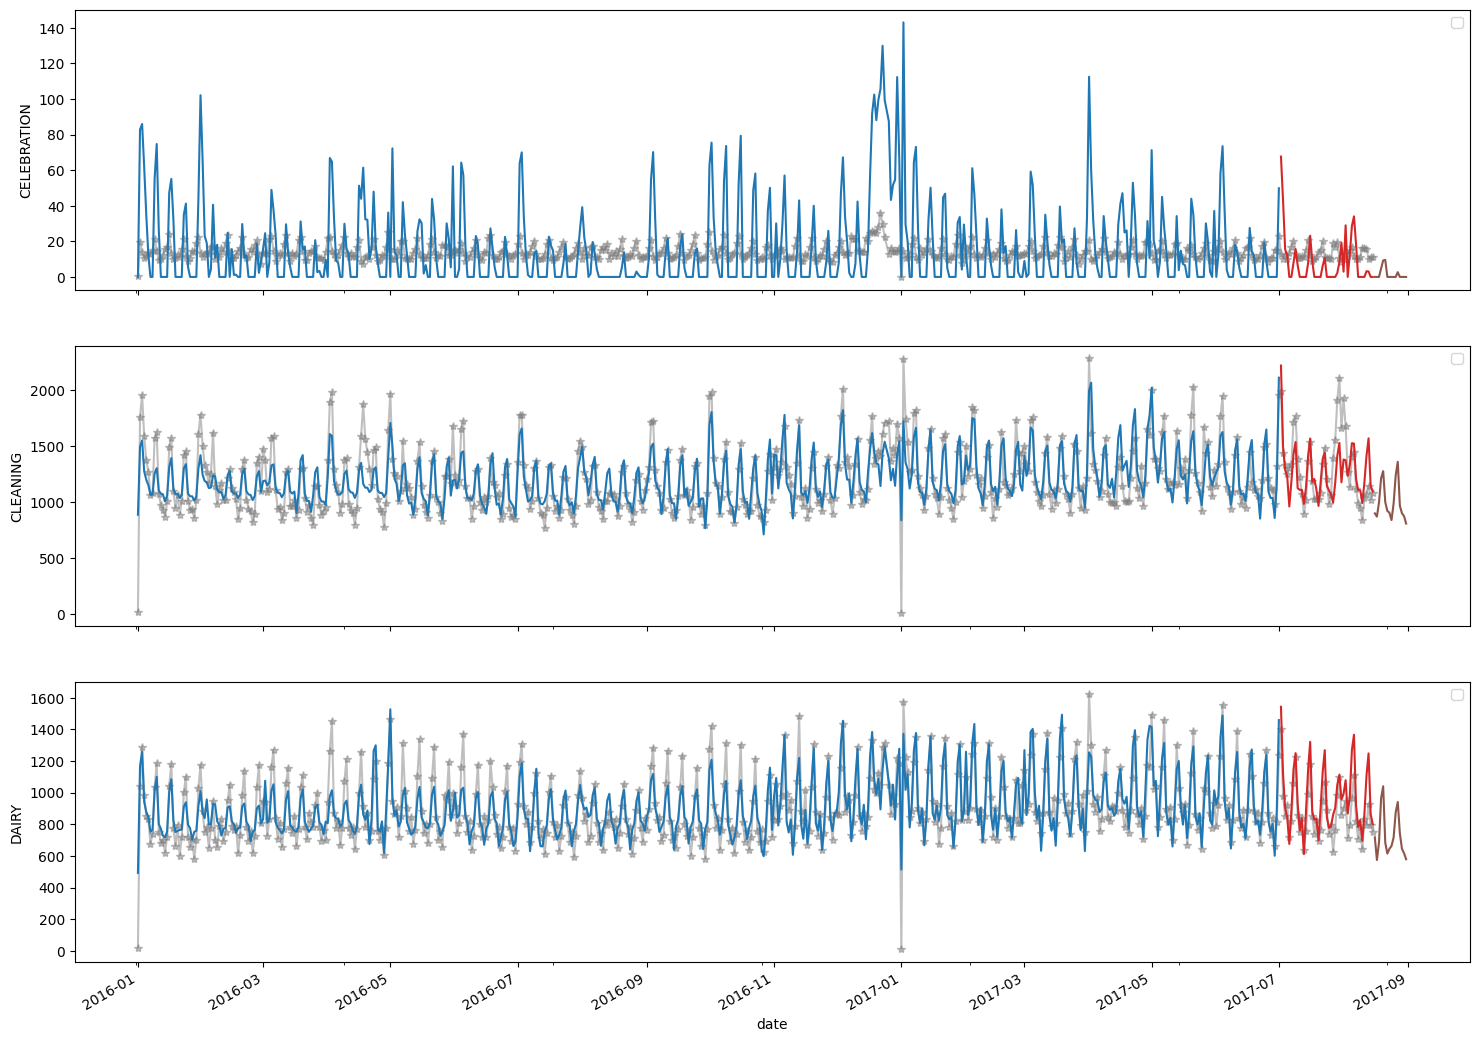

In [ ]:
#  from 6 to 9 categories cleaning, dairy and celebration. 

y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[:"2017-07-01"], X_1["2017-07-02":]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

new_model.fit(X1_train, X2_train, y_train)
y_fit = new_model.predict(X1_train, X2_train).clip(0.0)
y_pred = new_model.predict(X1_valid, X2_valid).clip(0.0)
y_fore = new_model.predict(test_X1, test_X2).clip(0.0)

families = y.columns[6:9] # printing for families 6 to 12
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(18,14), alpha=0.5, style='-*', color='grey'
)

_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C3',  ax=axs)
_ = y_fore.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C5',  ax=axs)

for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

___

* import test set, change structure to same as train set. 
* split X_1 and X_2 features, (Linear Regression and XGBoost features)
* the test set only contains data for the next 16 days, try to make it the next 30 days.
* what about the store number?

so far we have only applied on our model on the data we already have, we haven't forecasted anything(predict outside our training data)

The training set ends on 2017-08-15, which gives us the forecast origin. The test set comprises the dates 2017-08-16 to 2017-08-31, and this gives us the forecast horizon. There is one step between the origin and horizon, so we have a lead time of one day.
Put another way, we need a 16-step forecast with a 1-step lead time. We can use lags starting with lag 1, and we make the entire 16-step forecast using features from 2017-08-15.

# SARIMAX

In [48]:
family_sales = pd.read_csv(
    'family_sales.csv',
    index_col=0,          # Set 'date' as index (first column)
    parse_dates=True,     # Parse 'date' into datetime
    header=[0, 1]         # Two header rows for MultiIndex columns
)


family_sales.columns = pd.MultiIndex.from_tuples(
    family_sales.columns,
    names=['metric', 'family']  # Optional: name the column levels
)

# Display the DataFrame (now matches your original structure)
display(family_sales.head(3))

metric          sales                                                      \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES BOOKS BREAD/BAKERY   
date                                                                        
2013-01-01   0.000000       0.0  0.043478    17.608696   0.0     3.925848   
2013-01-02   5.543478       0.0  4.500000  1567.217391   0.0   570.572152   
2013-01-03   3.500000       0.0  2.717391  1132.717391   0.0   401.227827   

metric                                                       ... onpromotion  \
family     CELEBRATION     CLEANING       DAIRY        DELI  ...   MAGAZINES   
date                                                         ...               
2013-01-01         0.0     4.043478    3.108696    1.545435  ...         0.0   
2013-01-02         0.0  1622.369565  508.282609  342.489130  ...         0.0   
2013-01-03         0.0  1215.065217  391.326087  242.879457  ...         0.0   

metric                                                                       \
family     MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                          
2013-01-01   0.0           0.0          0.0                     0.0     0.0   
2013-01-02   0.0           0.0          0.0                     0.0     0.0   
2013-01-03   0.0           0.0          0.0                     0.0     0.0   

metric                                                                
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02            0.0     0.0                        0.0     0.0  
2013-01-03            0.0     0.0                        0.0     0.0  

[3 rows x 66 columns]

In [6]:
family_sales.shape

(1684, 66)

In [27]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima, ARIMA, model_selection

In [49]:
family_sales.index = pd.to_datetime(family_sales.index)
# Filter using the index
latest_family_sales = family_sales[family_sales.index.year >= 2016]

# Display the first few rows to verify
print(latest_family_sales.shape)
display(latest_family_sales.head())

(592, 66)


metric          sales                                                      \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES BOOKS BREAD/BAKERY   
date                                                                        
2016-01-01   0.075472  0.000000  0.245283    96.301887   0.0    12.848151   
2016-01-02  11.792453  0.169811  7.207547  4726.603774   0.0   631.407057   
2016-01-03  12.471698  0.320755  8.000000  5644.849057   0.0   771.799623   
2016-01-04   7.679245  0.339623  5.584906  4104.245283   0.0   590.167320   
2016-01-05   6.377358  0.075472  5.264151  3529.603774   0.0   513.016547   

metric                                                        ... onpromotion  \
family     CELEBRATION     CLEANING        DAIRY        DELI  ...   MAGAZINES   
date                                                          ...               
2016-01-01    0.245283    13.849057    19.490566    5.569453  ...         0.0   
2016-01-02   19.622642  1761.830189  1038.471698  426.252302  ...         0.0   
2016-01-03   13.811321  1953.660377  1290.018868  478.595604  ...         0.0   
2016-01-04   10.849057  1584.509434   985.698113  348.846925  ...         0.0   
2016-01-05   11.622642  1371.471698   852.339623  307.716019  ...         0.0   

metric                                                                   \
family         MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                      
2016-01-01  0.773585      0.018868     0.000000                     0.0   
2016-01-02  0.169811      0.943396     0.056604                     0.0   
2016-01-03  0.301887      0.849057     0.037736                     0.0   
2016-01-04  0.264151      0.716981     0.037736                     0.0   
2016-01-05  0.509434      0.698113     0.000000                     0.0   

metric                                                                     \
family       POULTRY PREPARED FOODS    PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                        
2016-01-01  0.509434       0.018868   0.000000                   0.000000   
2016-01-02  0.169811       0.018868   0.075472                   0.000000   
2016-01-03  0.245283       0.000000   0.264151                   0.056604   
2016-01-04  0.094340       0.000000   0.150943                   0.000000   
2016-01-05  0.320755       0.188679  48.547170                   0.000000   

metric                
family       SEAFOOD  
date                  
2016-01-01  0.037736  
2016-01-02  0.754717  
2016-01-03  0.000000  
2016-01-04  0.000000  
2016-01-05  0.000000  

[5 rows x 66 columns]

In [5]:
latest_family_sales.tail()

metric          sales                                                          \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-11   8.166667  0.129630  6.500000  3502.055556  0.000000   522.305296   
2017-08-12   7.462963  0.055556  6.833333  3376.259259  0.000000   507.473111   
2017-08-13   8.907407  0.166667  8.018519  3747.296296  0.018519   615.976981   
2017-08-14   5.407407  0.166667  6.240741  3237.629630  0.000000   518.564019   
2017-08-15   6.240741  0.148148  6.277778  3162.462963  0.000000   539.966574   

metric                                                       ... onpromotion  \
family     CELEBRATION     CLEANING       DAIRY        DELI  ...   MAGAZINES   
date                                                         ...               
2017-08-11   16.111111  1031.148148  831.648148  345.934963  ...         0.0   
2017-08-12   15.722222  1072.870370  793.592593  290.553574  ...         0.0   
2017-08-13   10.074074  1143.648148  928.000000  325.801371  ...         0.0   
2017-08-14   11.000000  1019.111111  797.222222  271.532241  ...         0.0   
2017-08-15   11.055556  1082.851852  753.833333  276.582463  ...         0.0   

metric                                                                    \
family          MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                       
2017-08-11  22.925926      9.000000          0.0                0.000000   
2017-08-12   0.000000      8.703704          0.0                0.018519   
2017-08-13   0.000000      9.240741          0.0                0.000000   
2017-08-14   0.000000      8.722222          0.0                0.000000   
2017-08-15   0.000000      8.814815          0.0                0.092593   

metric                                                                      \
family        POULTRY PREPARED FOODS    PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                         
2017-08-11  27.407407       0.537037   6.000000                   2.666667   
2017-08-12   0.111111       0.277778   6.000000                   2.759259   
2017-08-13   0.185185       0.222222   5.907407                   2.777778   
2017-08-14   0.129630       0.148148   6.018519                   2.851852   
2017-08-15   0.111111       0.166667  58.685185                   2.740741   

metric                
family       SEAFOOD  
date                  
2017-08-11  2.537037  
2017-08-12  0.759259  
2017-08-13  0.018519  
2017-08-14  0.000000  
2017-08-15  0.000000  

[5 rows x 66 columns]

### Using sarimax only on one family

In [50]:
# Select only 'AUTOMOTIVE' columns from both metrics
automotive_df = latest_family_sales.loc[:, (slice(None), 'AUTOMOTIVE')]

# Optional: rename columns for convenience
automotive_df.columns = automotive_df.columns.droplevel(1)  # Keep only 'sales' and 'onpromotion' as column names


In [7]:
automotive_df.head()

metric          sales  onpromotion
date                              
2016-01-01   0.075472     0.000000
2016-01-02  11.792453     0.000000
2016-01-03  12.471698     0.000000
2016-01-04   7.679245     0.169811
2016-01-05   6.377358     0.037736

In [32]:
automotive_df.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=592, freq=None)

In [ ]:
automotive_df.asfreq('D')

In [ ]:
# split into train and test data 
test_days = 30

train, test = automotive_df.iloc[:-test_days], automotive_df.iloc[-test_days:]
test

In [ ]:
# seperating the external factors 'onpromotion'
exg_train, exg_test = automotive_df.iloc[:-test_days, 1:], automotive_df.iloc[-test_days:, 1:]
exg_test

In [ ]:
test.index

In [ ]:
train.asfreq('D')

In [ ]:
test.asfreq('D')

In [56]:
model_sarimax = auto_arima(train['sales'], m =7, X = exg_train)
model_sarimax.summary()

c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\d

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  562
Model:             SARIMAX(5, 1, 2)x(2, 0, [1], 7)   Log Likelihood                -936.622
Date:                             Thu, 17 Apr 2025   AIC                           1899.244
Time:                                     22:41:39   BIC                           1955.530
Sample:                                          0   HQIC                          1921.220
                                             - 562                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept   -1.433e-06      0.000     -0.009      0.993      -0.000       0.000
onpromotion     2.1976      0.559      3.933      0.000       1.103       3.293
ar.L1          -0.3326      0.873     -0.381      0.703      -2.044       1.379
ar.L2           0.2009      0.294      0.683      0.494      -0.375       0.777
ar.L3           0.1023      0.065      1.569      0.117      -0.026       0.230
ar.L4           0.1555      0.086      1.800      0.072      -0.014       0.325
ar.L5           0.0270      0.108      0.250      0.802      -0.185       0.239
ma.L1          -0.3333      0.878     -0.380      0.704      -2.054       1.388
ma.L2          -0.6304      0.862     -0.731      0.465      -2.320       1.059
ar.S.L7         1.0334      0.059     17.459      0.000       0.917       1.149
ar.S.L14       -0.0376      0.059     -0.641      0.521      -0.153       0.077
ma.S.L7        -0.8379      0.027    -30.694      0.000      -0.891      -0.784
sigma2          1.6508      0.070     23.572      0.000       1.514       1.788
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):              2283.49
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.38
Prob(H) (two-sided):                  0.93   Kurtosis:                        12.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Test prediction of automotive sales in 30 days

predictions_sarimax = model_sarimax.predict(n_periods=len(test), X = exg_test)
predictions_sarimax

c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


562    6.331007
563    5.762583
564    5.519052
565    5.767498
566    6.060826
567    9.076627
568    9.378341
569    6.169838
570    5.827150
571    5.893657
572    5.678794
573    6.080080
574    9.104712
575    9.331314
576    6.179915
577    5.855843
578    5.472675
579    5.744619
580    6.023256
581    9.078449
582    9.301745
583    6.124568
584    5.761585
585    5.542930
586    5.691676
587    6.009753
588    9.051827
589    9.274037
590    6.110638
591    5.790009
dtype: float64

### RMSLE

In [58]:
msle = mean_squared_log_error(test['sales'], predictions_sarimax)
rmsle = np.sqrt(msle)
print(rmsle)

0.12191437019694117


In [ ]:
# function to plot and evaluate model

def model_assessment(train, test, pred, title):
    plt.figure(figsize=(10,4))
    plt.plot(train.index, train['sales'], label='Actual Data')
    plt.plot(test.index, test['sales'], label='Test Data')
    plt.plot(test.index, pred, label='Prediction', linestyle='--')
    plt.title(f'Train, test and predictions with {title}')
    plt.grid(True)
    plt.legend()
    plt.show()

        # calculating the MAE, RMSE, and MAPE
    mae = mean_absolute_error(test['sales'], pred)
    mse = mean_squared_error(test['sales'], pred)
    mape = mean_absolute_percentage_error(test['sales'], pred)
    

    rmse = np.sqrt(mse)


    print(f'the MAE is {mae:.2f}')
    print(f'The RMSE is {rmse:.2f}')
    print(f'The MAPE is {100 * mape:.2f} %')


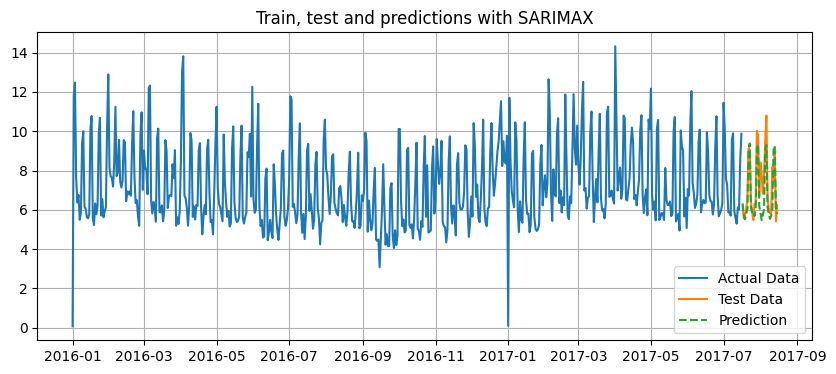

the MAE is 0.70
The RMSE is 0.99
The MAPE is 9.34 %


In [ ]:
# Visually compare the actual data against the prediction

model_assessment(train, test, predictions_sarimax, 'SARIMAX')

### forecast with SARIMAX

In [46]:
sales = automotive_df[['sales']]
exg = automotive_df[['onpromotion']]

In [47]:
models_sarimax = auto_arima(sales, m=7, X= exg)
models_sarimax.summary()

c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\d

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  592
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -982.669
Date:                           Thu, 10 Apr 2025   AIC                           1983.339
Time:                                   23:06:44   BIC                           2022.775
Sample:                                        0   HQIC                          1998.701
                                           - 592                                         
Covariance Type:                             opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept   -2.377e-06   6.38e-05     -0.037      0.970      -0.000       0.000
onpromotion     2.1408      0.503      4.252      0.000       1.154       3.128
ar.L1           0.2769      0.034      8.251      0.000       0.211       0.343
ar.L2           0.0258      0.047      0.553      0.581      -0.066       0.118
ar.L3           0.0961      0.053      1.822      0.068      -0.007       0.199
ma.L1          -0.9691      0.017    -56.695      0.000      -1.003      -0.936
ar.S.L7         0.9984      0.001   1394.146      0.000       0.997       1.000
ma.S.L7        -0.8301      0.019    -42.716      0.000      -0.868      -0.792
sigma2          1.5628      0.057     27.185      0.000       1.450       1.676
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2280.32
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.42
Prob(H) (two-sided):                  0.49   Kurtosis:                        12.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1]:
import pandas as pd 

test_set = pd.read_csv('test.csv')

test_set.head()

id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0

In [2]:
test_set.index = pd.to_datetime(test_set.index)

In [6]:
external_feat = (
    test_set.groupby(['family', 'date']).mean().unstack('family')
    .loc[:,['onpromotion']]
)

external_feat.head()

onpromotion                                                    \
family      AUTOMOTIVE BABY CARE    BEAUTY  BEVERAGES BOOKS BREAD/BAKERY   
date                                                                       
2017-08-16    0.000000  0.000000  2.000000  31.592593   0.0    13.944444   
2017-08-17    0.000000  0.000000  0.851852  18.759259   0.0     8.148148   
2017-08-18    0.000000  0.000000  0.888889  18.777778   0.0     9.166667   
2017-08-19    0.000000  0.018519  1.000000  20.203704   0.0     9.314815   
2017-08-20    0.018519  0.000000  0.944444  20.574074   0.0    32.000000   

                                                         ...            \
family     CELEBRATION   CLEANING      DAIRY       DELI  ... MAGAZINES   
date                                                     ...             
2017-08-16    0.000000  26.888889  84.759259  18.055556  ...       0.0   
2017-08-17    0.018519  13.425926  12.277778   6.462963  ...       0.0   
2017-08-18    0.000000  14.518519  16.037037  55.222222  ...       0.0   
2017-08-19    0.037037  16.055556  16.611111   7.611111  ...       0.0   
2017-08-20    0.000000  15.814815  16.425926   7.870370  ...       0.0   

                                                                          \
family          MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                       
2017-08-16   0.018519     18.000000     0.000000                0.148148   
2017-08-17   8.981481      8.740741     0.018519                0.074074   
2017-08-18  22.796296      9.907407     0.000000                0.148148   
2017-08-19   0.037037     10.722222     0.000000                0.203704   
2017-08-20   0.000000     11.203704     0.000000                0.129630   

                                                                             \
family        POULTRY PREPARED FOODS     PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                          
2017-08-16   0.185185       0.148148  223.314815                  13.592593   
2017-08-17   0.092593       0.018519    2.074074                   2.629630   
2017-08-18  25.240741       0.370370    2.611111                   2.407407   
2017-08-19   0.092593       0.000000    2.833333                   2.740741   
2017-08-20   0.129630       0.000000    2.814815                   2.814815   

                      
family       SEAFOOD  
date                  
2017-08-16  0.000000  
2017-08-17  0.000000  
2017-08-18  2.592593  
2017-08-19  0.777778  
2017-08-20  0.000000  

[5 rows x 33 columns]

In [ ]:
# code to add the promotional values from 2016 september to 2017 september because we dont have those bcuz test ends in 31 august.

# First, let's identify the data we want to copy from family_sales
# Get data from 2016-09-01 to 2016-09-16
start_date_source = '2016-09-01'
end_date_source = '2016-09-16'
promo_data_to_copy = family_sales.loc[start_date_source:end_date_source, ('onpromotion', slice(None))]

# Create new dates for the target dataframe
# These will be the same dates but in 2017 instead of 2016
new_dates = pd.date_range(start='2017-09-01', end='2017-09-16')

# Create a DataFrame with the new dates but data from 2016
new_data = pd.DataFrame(
    index=new_dates,
    data=promo_data_to_copy.values,
    columns=promo_data_to_copy.columns
)

# Now append this data to external_feat
external_feat_extended = pd.concat([external_feat, new_data])


# Display the result to confirm
print(external_feat_extended.tail(20))  # Check the last 20 rows to see both old and new data

                    onpromotion                                       \
family               AUTOMOTIVE BABY CARE    BEAUTY  BEVERAGES BOOKS   
2017-08-28             0.037037  0.000000  0.555556  27.203704   0.0   
2017-08-29             0.000000  0.000000  0.537037  26.537037   0.0   
2017-08-30             0.129630  0.000000  0.537037  43.037037   0.0   
2017-08-31             0.129630  0.000000  0.555556  34.888889   0.0   
2017-09-01 00:00:00    0.000000  0.000000  0.150943  18.000000   0.0   
2017-09-02 00:00:00    0.018868  0.000000  0.150943  18.962264   0.0   
2017-09-03 00:00:00    0.000000  0.000000  0.150943  19.754717   0.0   
2017-09-04 00:00:00    0.018868  0.000000  0.132075  19.849057   0.0   
2017-09-05 00:00:00    0.000000  0.000000  0.132075  16.415094   0.0   
2017-09-06 00:00:00    0.000000  0.000000  0.113208  14.773585   0.0   
2017-09-07 00:00:00    0.018868  0.000000  0.150943  14.886792   0.0   
2017-09-08 00:00:00    0.000000  0.000000  0.037736  13.886792  

In [22]:
external_feat_extended.tail()

onpromotion                                    \
family               AUTOMOTIVE BABY CARE BEAUTY  BEVERAGES BOOKS   
2017-09-12 00:00:00         0.0       0.0    0.0   9.886792   0.0   
2017-09-13 00:00:00         0.0       0.0    0.0   9.000000   0.0   
2017-09-14 00:00:00         0.0       0.0    0.0  10.000000   0.0   
2017-09-15 00:00:00         0.0       0.0    0.0  27.075472   0.0   
2017-09-16 00:00:00         0.0       0.0    0.0  30.584906   0.0   

                                                                               \
family              BREAD/BAKERY CELEBRATION   CLEANING      DAIRY       DELI   
2017-09-12 00:00:00     9.509434    0.075472  16.905660   5.547170   2.396226   
2017-09-13 00:00:00     9.509434    0.132075  16.924528   5.075472   3.471698   
2017-09-14 00:00:00     9.339623    0.056604  16.943396  49.716981   3.603774   
2017-09-15 00:00:00     8.905660    0.094340  35.358491   4.509434   3.584906   
2017-09-16 00:00:00     9.207547    0.075472  36.415094   4.566038  50.245283   

                     ...                                                  \
family               ... MAGAZINES      MEATS PERSONAL CARE PET SUPPLIES   
2017-09-12 00:00:00  ...       0.0   0.056604      6.433962          0.0   
2017-09-13 00:00:00  ...       0.0   0.056604      7.169811          0.0   
2017-09-14 00:00:00  ...       0.0   0.113208      8.075472          0.0   
2017-09-15 00:00:00  ...       0.0   9.094340      7.754717          0.0   
2017-09-16 00:00:00  ...       0.0  21.962264      7.433962          0.0   

                                                                       \
family              PLAYERS AND ELECTRONICS    POULTRY PREPARED FOODS   
2017-09-12 00:00:00                0.000000   0.000000       0.471698   
2017-09-13 00:00:00                0.000000   0.000000       0.679245   
2017-09-14 00:00:00                0.000000   0.018868       3.811321   
2017-09-15 00:00:00                0.018868   0.000000       0.490566   
2017-09-16 00:00:00                0.000000  24.301887       1.113208   

                                                                     
family                 PRODUCE SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
2017-09-12 00:00:00   0.490566                   1.490566  0.716981  
2017-09-13 00:00:00  46.075472                   1.339623  0.377358  
2017-09-14 00:00:00  94.301887                   1.169811  0.339623  
2017-09-15 00:00:00   0.528302                   0.075472  0.320755  
2017-09-16 00:00:00   0.981132                   0.056604  2.716981  

[5 rows x 33 columns]

In [20]:
autoext = external_feat_extended['onpromotion'][['AUTOMOTIVE']]
autoext.tail()

family               AUTOMOTIVE
2017-09-12 00:00:00         0.0
2017-09-13 00:00:00         0.0
2017-09-14 00:00:00         0.0
2017-09-15 00:00:00         0.0
2017-09-16 00:00:00         0.0

In [10]:
autoext.tail()

family      AUTOMOTIVE
date                  
2017-08-27    0.000000
2017-08-28    0.037037
2017-08-29    0.000000
2017-08-30    0.129630
2017-08-31    0.129630

In [64]:
autoext.index = pd.to_datetime(autoext.index)

In [ ]:
pred_sarimax = models_sarimax.predict(n_periods=32, X= autoext)
pred_sarimax

In [65]:
# functions to forecast the sales

def model_forecast(train, pred, title):
    plt.figure(figsize=(10,4))
    plt.plot(train.index, train['sales'], label='Actual Data')
    plt.plot(autoext.index, pred, label='Forecast', linestyle='--', color='red')
    plt.title(f'Forecast with {title}')
    plt.grid(True)
    plt.legend()
    plt.show()

   

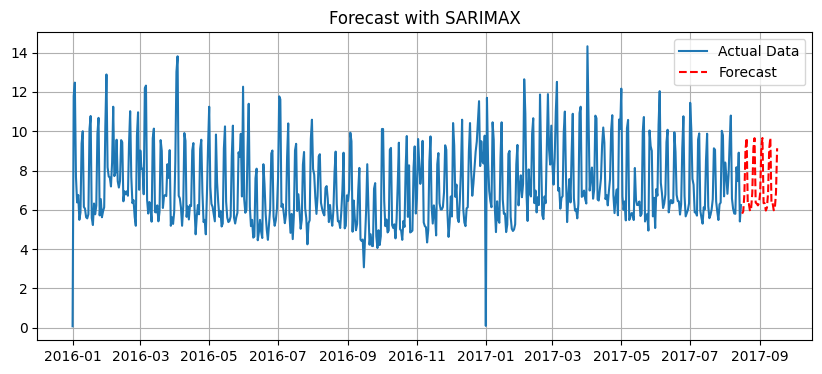

In [66]:
# see if the forecast keeps up with the trend

model_forecast(automotive_df, pred_sarimax, 'SARIMAX')

In [83]:
# create a function that does all of this

def forecast_with_sarimax(data, family, forecast_horizon=30):
    df = data.loc[:, (slice(None), family)]
    df.columns = df.columns.droplevel(1) # to convert from multiindex

    sales = df[['sales']]
    exg = df[['onpromotion']]

    model = auto_arima(sales, m=7, X=exg) # training the model
    model.summary()

    # Get the last 30 days of 'onpromotion' values
    onpromotion_lags = df['onpromotion'].tail(forecast_horizon).reset_index(drop=True)

    last_date = df.index[-1]
    next_days = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon)

    # Create the new DataFrame
    external_factors_df = pd.DataFrame({
        'onpromotion': onpromotion_lags.values  # reuse the values
    }, index=next_days)

    preds = model.predict(n_periods=forecast_horizon, X = external_factors_df)
    preds 

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['sales'], label='Actual')
    plt.plot(external_factors_df.index, preds, label='Forecast', linestyle='--', color='red')
    plt.title(f'Forecast with SARIMAX for {family} Category')
    plt.grid(True)
    plt.legend()
    plt.show()

c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\d

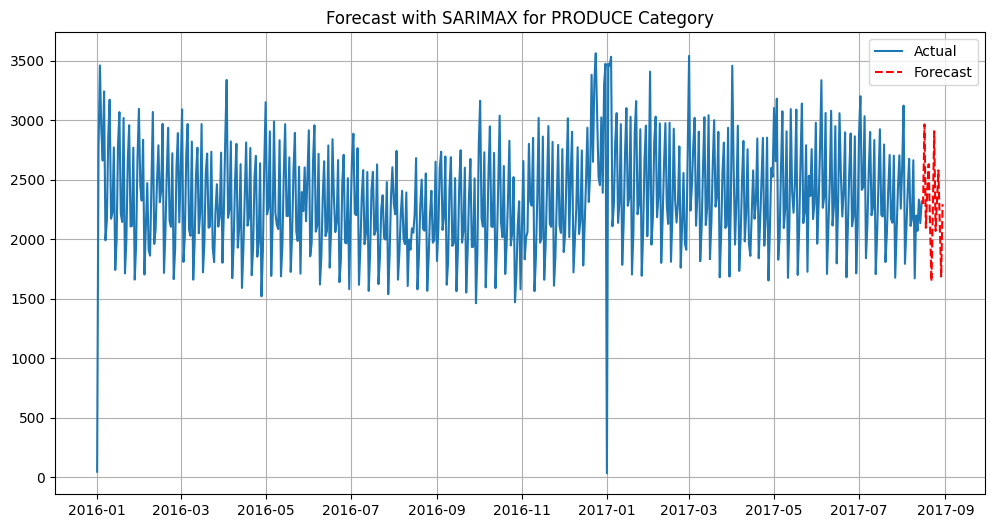

In [84]:
forecast_with_sarimax(latest_family_sales, 'PRODUCE', 15)

## Prophet

Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model. 
* datetime column named: ds
* target: y

In [4]:
automotive_df = latest_family_sales.loc[:, (slice(None), 'AUTOMOTIVE')]

# Optional: rename columns for convenience
automotive_df.columns = automotive_df.columns.droplevel(1)  # Keep only 'sales' and 'onpromotion' as column names

In [5]:
# from cell 30

automotive_df.head()

metric          sales  onpromotion
date                              
2016-01-01   0.075472     0.000000
2016-01-02  11.792453     0.000000
2016-01-03  12.471698     0.000000
2016-01-04   7.679245     0.169811
2016-01-05   6.377358     0.037736

In [17]:
prophet_df = automotive_df.reset_index().rename(columns={
    'date': 'ds',
    'sales': 'y'
})

In [18]:
# Initialize the Prophet model
model = Prophet()

# Add the promotion feature as a regressor
model.add_regressor('onpromotion')

# Fit the model
model.fit(prophet_df)

06:48:04 - cmdstanpy - INFO - Chain [1] start processing
06:48:04 - cmdstanpy - INFO - Chain [1] done processing


C:\Users\ahmed\AppData\Local\Temp\ipykernel_36616\492069485.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future['onpromotion'].fillna(0, inplace=True)


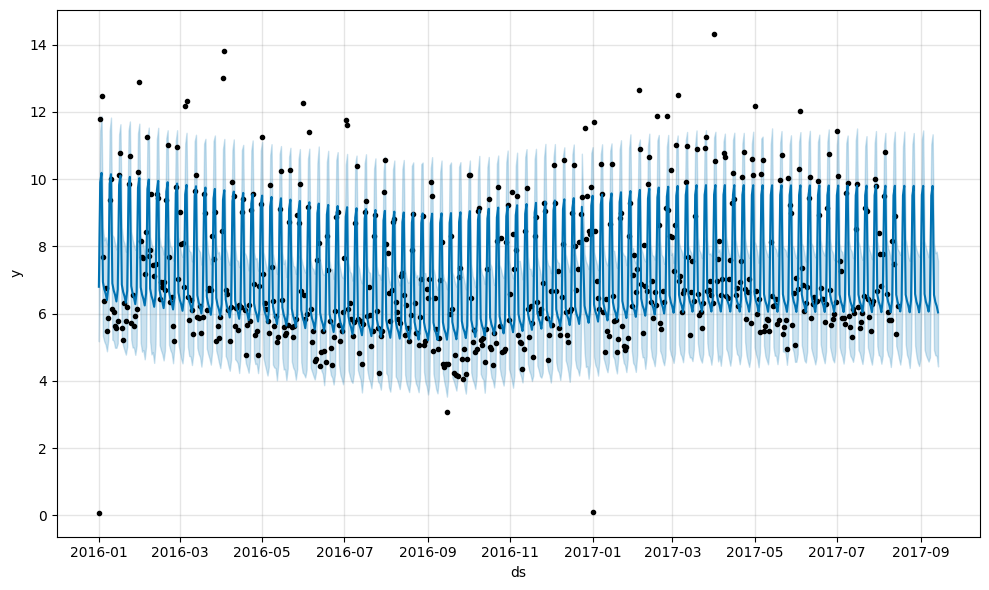

In [20]:
future = model.make_future_dataframe(periods=30)  # Forecast 30 days ahead


start_date_source = '2016-08-16'
end_date_source = '2016-09-14'
promo_source = automotive_df.loc[start_date_source:end_date_source, 'onpromotion'].reset_index(drop=True)

future_extra = future[-30:].copy()

# Assign promo_source to future_extra
future_extra['onpromotion'] = promo_source.values

future.loc[future_extra.index, 'onpromotion'] = future_extra['onpromotion']

# Fill any missing 'onpromotion' in earlier dates if needed
future['onpromotion'].fillna(0, inplace=True)

# 7. Predict
forecast = model.predict(future)

fig = model.plot(forecast)

ds      yhat  yhat_lower  yhat_upper
617 2017-09-10  9.799786    8.169396   11.335757
618 2017-09-11  6.559179    4.914494    8.103779
619 2017-09-12  6.348792    4.763192    7.797070
620 2017-09-13  6.226233    4.744039    7.843095
621 2017-09-14  6.036040    4.430033    7.568743

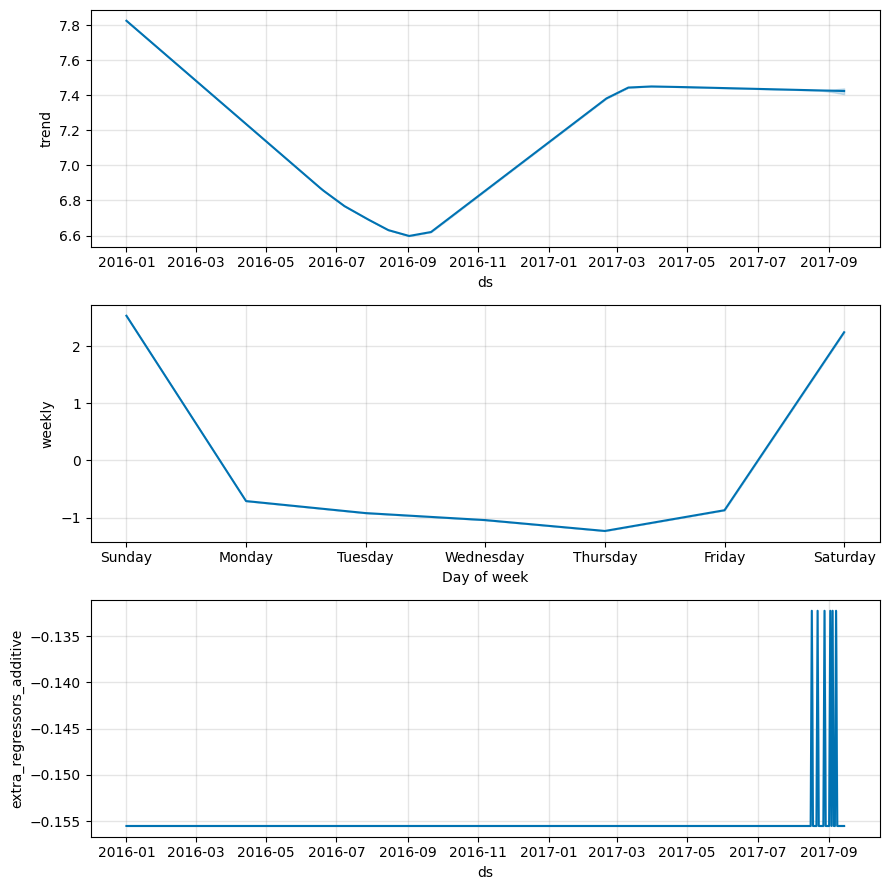

In [ ]:
# Plot the forecast components
fig2 = model.plot_components(forecast)
# View the forecast dataframe
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

## Error metric evaluation

In [12]:
# creatinig a new dataframe by combining the predicted data and actual data.

comparison = pd.merge(prophet_df[['ds', 'y']], forecast[['ds', 'yhat']], on='ds')

In [13]:
mae = np.mean(np.abs(comparison['y'] - comparison['yhat']))
rmse = np.sqrt(np.mean((comparison['y'] - comparison['yhat'])**2))
mape = np.mean(np.abs((comparison['y'] - comparison['yhat']) / comparison['y'])) * 100

print("\nModel performance metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Model performance metrics:
Mean Absolute Error (MAE): 0.8396
Root Mean Squared Error (RMSE): 1.2602
Mean Absolute Percentage Error (MAPE): 43.04%


43% MAPE indicates model is in the acceptable but not great. There is room for more improvement

In [14]:
# RMSLE

msle = mean_squared_log_error(comparison['y'], comparison['yhat'])
rmsle = np.sqrt(msle)
print(f'The RMSLE is {rmsle}')

The RMSLE is 0.18310424461449956


In [15]:
# this is function created to use the prophet model, based on the specific family and the no of days in the future.

def forecast_with_prophet(data, family, forecast_horizon=30):
    # Extract data for the specified family
    df = data.loc[:, (slice(None), family)]
    df.columns = df.columns.droplevel(1)
    
    # Create Prophet dataframe
    prophet_df = df.reset_index().rename(columns={'date': 'ds', 'sales': 'y'})
    
    # Initialize the Prophet model
    model = Prophet()
    
    # Add the promotion feature as a regressor
    model.add_regressor('onpromotion')
    
    # Fit the model
    model.fit(prophet_df)
    
    # Create future dataframe for predictions
    future = model.make_future_dataframe(periods=forecast_horizon)
    
    # Initialize onpromotion column with zeros
    future['onpromotion'] = 0
    
    # Set known onpromotion values
    start_date_source = pd.to_datetime('2016-08-16')
    end_date_source = start_date_source + pd.Timedelta(days=forecast_horizon - 1)
    promo_source = automotive_df.loc[start_date_source:end_date_source, 'onpromotion'].reset_index(drop=True)

    future_extra = future[-forecast_horizon:].copy()

    # Assign promo_source to future_extra
    future_extra['onpromotion'] = promo_source.values

    future.loc[future_extra.index, 'onpromotion'] = future_extra['onpromotion']

    # 6. Fill any missing 'onpromotion' in earlier dates if needed
    future['onpromotion'].fillna(0, inplace=True)

    
    # Make the forecast
    forecast = model.predict(future)
    
    # Plot the results
    fig = model.plot(forecast)
    
    # Add components plot
    fig_components = model.plot_components(forecast)

    print("Forecast results:")
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(forecast_horizon))
    
    # Return the forecast dataframe and figures
    return fig, fig_components

yhat are the predicted values

06:45:51 - cmdstanpy - INFO - Chain [1] start processing
06:45:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\ahmed\AppData\Local\Temp\ipykernel_36616\3012561634.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.         0.01886792 0.         0.         0.         0.
 0.01886792 0.         0.         0.         0.         0.
 0.01886792 0.         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[future_extra.index, 'onpromotion'] = future_extra['onpromotion']
C:\Users\ahmed\AppData\Local\Temp\ipykernel_36616\3012561634.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

Forecast results:
            ds      yhat  yhat_lower  yhat_upper
592 2017-08-16  3.769788    2.354155    5.218320
593 2017-08-17  3.386149    1.934739    4.813343
594 2017-08-18  3.754714    2.385246    5.087855
595 2017-08-19  6.045866    4.744372    7.545962
596 2017-08-20  7.004592    5.606853    8.404714
597 2017-08-21  4.215364    2.811447    5.604296
598 2017-08-22  3.908049    2.588802    5.289093
599 2017-08-23  3.777992    2.246283    5.147149
600 2017-08-24  3.366050    1.888829    4.822892
601 2017-08-25  3.762918    2.393239    5.279247
602 2017-08-26  6.054070    4.680640    7.554960
603 2017-08-27  7.012797    5.576187    8.495837
604 2017-08-28  4.251871    2.788734    5.668992
605 2017-08-29  3.887950    2.443168    5.280786
606 2017-08-30  3.786196    2.179172    5.263506


(<Figure size 1000x600 with 1 Axes>, <Figure size 900x900 with 3 Axes>)

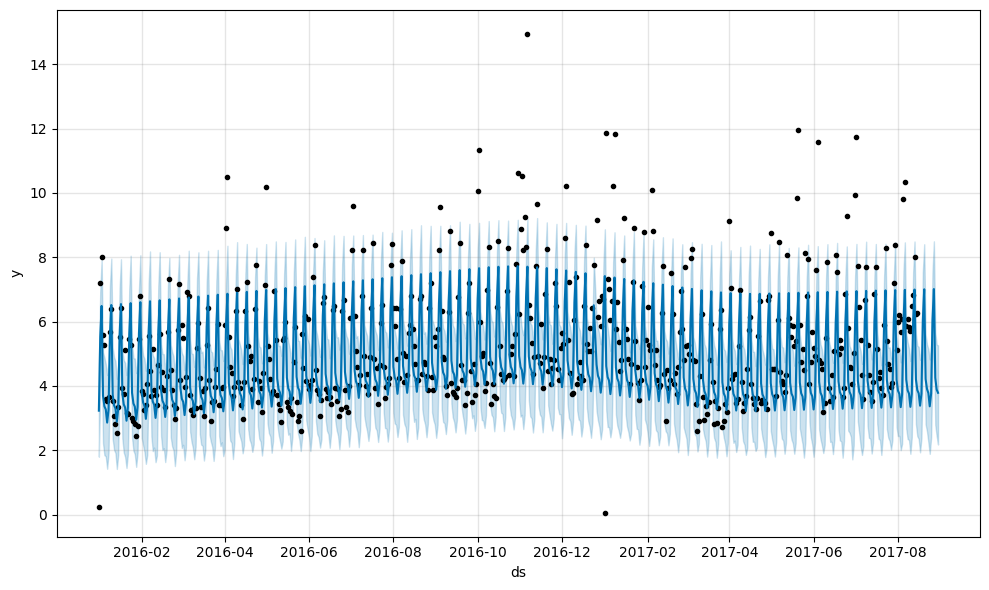

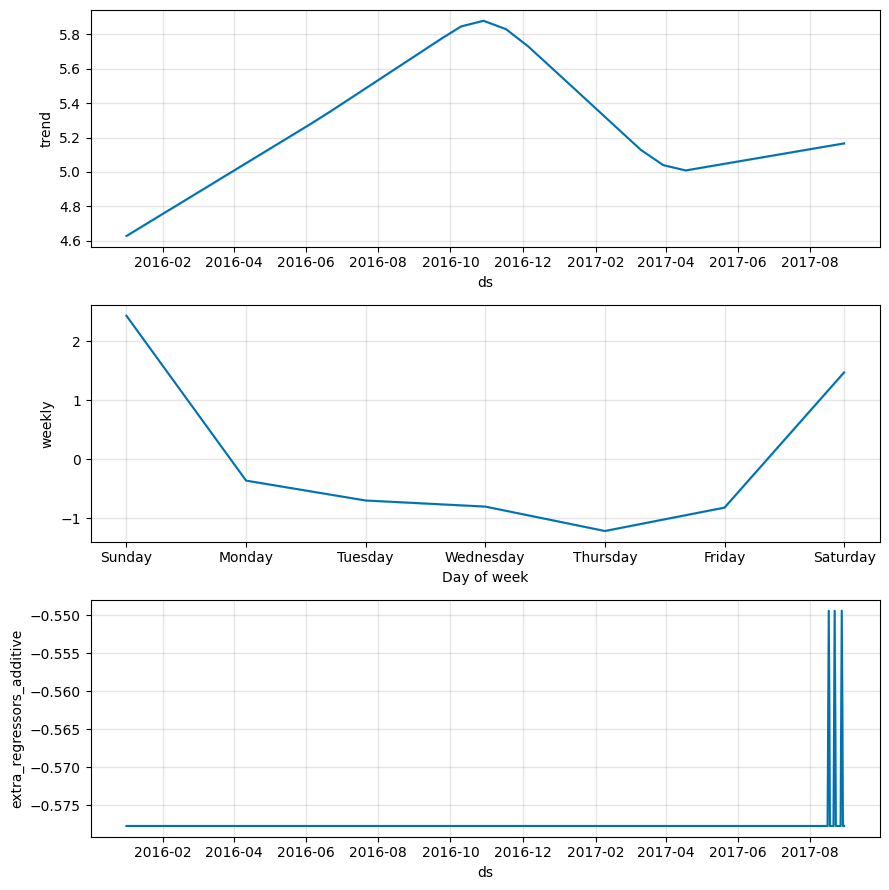

In [16]:
forecast_with_prophet(latest_family_sales, 'BEAUTY', 15)

 the "extra_regressors_additive" component, which represents how much the 'onpromotion' variable contributes to the overall forecast over time. In Prophet, this shows the estimated effect of promotions on your sales data.

# LGBM

2 EXTRA FEATURES IS_HOLIDAY AND LAGS. YOU CAN EASILY PUT LAGS IN TRAIN, BUT FOR TEST SET IT CAN BE TRICKY. YOU HAVE ALREADY CREATED THE IS_HOLIDAY FEATURE HERE SOMEWHERE

* merge the holiday data
* create is_holiday column
* create day, month, day_of_week.
* create lag1, lag2, lag7, lag14, lag28
* remove datas before 2016
* train test split
* train the lgbm model, test the model
* plot the train and test predictions and values
* evaluate with the error metrics
* make improvements if necessary 
* import test data, in excel go and add extra 14 days, must predict for atleast 30 days ahead, use promotional values from last year
* create the same columns as the train data
* create function to predict lags and add it to the lag columns in the test set


In [ ]:
df = pd.read_csv('train.csv')
df.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [ ]:
df.tail()

id        date  store_nbr                      family     sales  \
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0

In [ ]:
holiday = pd.read_csv('holidays_events.csv')

In [ ]:
holiday.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [6]:
# new dataframe
mdf = pd.merge(df, holiday, on='date', how='left')
mdf['is_holiday'] = np.where(mdf['type'].isna(), 0, 1)
mdf.head()


id        date  store_nbr      family  sales  onpromotion     type  \
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0  Holiday   
1   1  2013-01-01          1   BABY CARE    0.0            0  Holiday   
2   2  2013-01-01          1      BEAUTY    0.0            0  Holiday   
3   3  2013-01-01          1   BEVERAGES    0.0            0  Holiday   
4   4  2013-01-01          1       BOOKS    0.0            0  Holiday   

     locale locale_name         description transferred  is_holiday  
0  National     Ecuador  Primer dia del ano       False           1  
1  National     Ecuador  Primer dia del ano       False           1  
2  National     Ecuador  Primer dia del ano       False           1  
3  National     Ecuador  Primer dia del ano       False           1  
4  National     Ecuador  Primer dia del ano       False           1

In [7]:
mdf['is_holiday'].value_counts()

is_holiday
0    2551824
1     502524
Name: count, dtype: int64

In [8]:
mdf = mdf.drop(columns=['type', 'locale', 'locale_name', 'description', 'transferred'])
mdf.head()

id        date  store_nbr      family  sales  onpromotion  is_holiday
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0           1
1   1  2013-01-01          1   BABY CARE    0.0            0           1
2   2  2013-01-01          1      BEAUTY    0.0            0           1
3   3  2013-01-01          1   BEVERAGES    0.0            0           1
4   4  2013-01-01          1       BOOKS    0.0            0           1

In [9]:
mdf = mdf.drop(columns=['id'])

In [10]:
mdf.set_index('date', inplace=True)

In [11]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3054348 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   store_nbr    int64  
 1   family       object 
 2   sales        float64
 3   onpromotion  int64  
 4   is_holiday   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 139.8+ MB


In [12]:
mdf.head()

store_nbr      family  sales  onpromotion  is_holiday
date                                                             
2013-01-01          1  AUTOMOTIVE    0.0            0           1
2013-01-01          1   BABY CARE    0.0            0           1
2013-01-01          1      BEAUTY    0.0            0           1
2013-01-01          1   BEVERAGES    0.0            0           1
2013-01-01          1       BOOKS    0.0            0           1

In [13]:
# convert date to datetime type

mdf.index = pd.to_datetime(mdf.index)

In [14]:
# feature engineer to create new features

mdf['day'] = mdf.index.day
mdf['month'] = mdf.index.month
mdf['day_of_week'] = mdf.index.dayofweek
mdf.head()

store_nbr      family  sales  onpromotion  is_holiday  day  month  \
date                                                                            
2013-01-01          1  AUTOMOTIVE    0.0            0           1    1      1   
2013-01-01          1   BABY CARE    0.0            0           1    1      1   
2013-01-01          1      BEAUTY    0.0            0           1    1      1   
2013-01-01          1   BEVERAGES    0.0            0           1    1      1   
2013-01-01          1       BOOKS    0.0            0           1    1      1   

            day_of_week  
date                     
2013-01-01            1  
2013-01-01            1  
2013-01-01            1  
2013-01-01            1  
2013-01-01            1

In [15]:
# create lag features for sales value

mdf = mdf.sort_values(['store_nbr', 'family', 'date'])
for lag in [1, 2, 7, 14, 28]:
    mdf[f'sales_lag_{lag}'] = mdf.groupby(['store_nbr', 'family'])['sales'].shift(lag)

mdf.head(25)

store_nbr      family  sales  onpromotion  is_holiday  day  month  \
date                                                                            
2013-01-01          1  AUTOMOTIVE    0.0            0           1    1      1   
2013-01-02          1  AUTOMOTIVE    2.0            0           0    2      1   
2013-01-03          1  AUTOMOTIVE    3.0            0           0    3      1   
2013-01-04          1  AUTOMOTIVE    3.0            0           0    4      1   
2013-01-05          1  AUTOMOTIVE    5.0            0           1    5      1   
2013-01-06          1  AUTOMOTIVE    2.0            0           0    6      1   
2013-01-07          1  AUTOMOTIVE    0.0            0           0    7      1   
2013-01-08          1  AUTOMOTIVE    2.0            0           0    8      1   
2013-01-09          1  AUTOMOTIVE    2.0            0           0    9      1   
2013-01-10          1  AUTOMOTIVE    2.0            0           0   10      1   
2013-01-11          1  AUTOMOTIVE    3.0            0           0   11      1   
2013-01-12          1  AUTOMOTIVE    2.0            0           1   12      1   
2013-01-13          1  AUTOMOTIVE    2.0            0           0   13      1   
2013-01-14          1  AUTOMOTIVE    2.0            0           0   14      1   
2013-01-15          1  AUTOMOTIVE    1.0            0           0   15      1   
2013-01-16          1  AUTOMOTIVE    1.0            0           0   16      1   
2013-01-17          1  AUTOMOTIVE    1.0            0           0   17      1   
2013-01-18          1  AUTOMOTIVE    0.0            0           0   18      1   
2013-01-19          1  AUTOMOTIVE    5.0            0           0   19      1   
2013-01-20          1  AUTOMOTIVE    3.0            0           0   20      1   
2013-01-21          1  AUTOMOTIVE    1.0            0           0   21      1   
2013-01-22          1  AUTOMOTIVE    1.0            0           0   22      1   
2013-01-23          1  AUTOMOTIVE    3.0            0           0   23      1   
2013-01-24          1  AUTOMOTIVE    0.0            0           0   24      1   
2013-01-25          1  AUTOMOTIVE    5.0            0           0   25      1   

            day_of_week  sales_lag_1  sales_lag_2  sales_lag_7  sales_lag_14  \
date                                                                           
2013-01-01            1          NaN          NaN          NaN           NaN   
2013-01-02            2          0.0          NaN          NaN           NaN   
2013-01-03            3          2.0          0.0          NaN           NaN   
2013-01-04            4          3.0          2.0          NaN           NaN   
2013-01-05            5          3.0          3.0          NaN           NaN   
2013-01-06            6          5.0          3.0          NaN           NaN   
2013-01-07            0          2.0          5.0          NaN           NaN   
2013-01-08            1          0.0          2.0          0.0           NaN   
2013-01-09            2          2.0          0.0          2.0           NaN   
2013-01-10            3          2.0          2.0          3.0           NaN   
2013-01-11            4          2.0          2.0          3.0           NaN   
2013-01-12            5          3.0          2.0          5.0           NaN   
2013-01-13            6          2.0          3.0          2.0           NaN   
2013-01-14            0          2.0          2.0          0.0           NaN   
2013-01-15            1          2.0          2.0          2.0           0.0   
2013-01-16            2          1.0          2.0          2.0           2.0   
2013-01-17            3          1.0          1.0          2.0           3.0   
2013-01-18            4          1.0          1.0          3.0           3.0   
2013-01-19            5          0.0          1.0          2.0           5.0   
2013-01-20            6          5.0          0.0          2.0           2.0   
2013-01-21            0          3.0          5.0          2.0  

In [16]:
mdf.tail()

store_nbr   family  sales  onpromotion  is_holiday  day  month  \
date                                                                         
2017-08-11         54  SEAFOOD    0.0            0           1   11      8   
2017-08-12         54  SEAFOOD    1.0            1           0   12      8   
2017-08-13         54  SEAFOOD    2.0            0           0   13      8   
2017-08-14         54  SEAFOOD    0.0            0           0   14      8   
2017-08-15         54  SEAFOOD    3.0            0           1   15      8   

            day_of_week  sales_lag_1  sales_lag_2  sales_lag_7  sales_lag_14  \
date                                                                           
2017-08-11            4          2.0          4.0          0.0           4.0   
2017-08-12            5          0.0          2.0          3.0           4.0   
2017-08-13            6          1.0          0.0          0.0           4.0   
2017-08-14            0          2.0          1.0          0.0           4.0   
2017-08-15            1          0.0          2.0         12.0           3.0   

            sales_lag_28  
date                      
2017-08-11           0.0  
2017-08-12           2.0  
2017-08-13           5.0  
2017-08-14           3.0  
2017-08-15           6.0

In [17]:
late_df = mdf[mdf.index.year >= 2016]
late_df

store_nbr      family  sales  onpromotion  is_holiday  day  month  \
date                                                                            
2016-01-01          1  AUTOMOTIVE    0.0            0           1    1      1   
2016-01-02          1  AUTOMOTIVE    7.0            0           0    2      1   
2016-01-03          1  AUTOMOTIVE    1.0            0           0    3      1   
2016-01-04          1  AUTOMOTIVE    8.0            0           0    4      1   
2016-01-05          1  AUTOMOTIVE    7.0            0           0    5      1   
...               ...         ...    ...          ...         ...  ...    ...   
2017-08-11         54     SEAFOOD    0.0            0           1   11      8   
2017-08-12         54     SEAFOOD    1.0            1           0   12      8   
2017-08-13         54     SEAFOOD    2.0            0           0   13      8   
2017-08-14         54     SEAFOOD    0.0            0           0   14      8   
2017-08-15         54     SEAFOOD    3.0            0           1   15      8   

            day_of_week  sales_lag_1  sales_lag_2  sales_lag_7  sales_lag_14  \
date                                                                           
2016-01-01            4          5.0          5.0          4.0           0.0   
2016-01-02            5          0.0          5.0          7.0           3.0   
2016-01-03            6          7.0          0.0          4.0           0.0   
2016-01-04            0          1.0          7.0          4.0           1.0   
2016-01-05            1          8.0          1.0          8.0           9.0   
...                 ...          ...          ...          ...           ...   
2017-08-11            4          2.0          4.0          0.0           4.0   
2017-08-12            5          0.0          2.0          3.0           4.0   
2017-08-13            6          1.0          0.0          0.0           4.0   
2017-08-14            0          2.0          1.0          0.0           4.0   
2017-08-15            1          0.0          2.0         12.0           3.0   

            sales_lag_28  
date                      
2016-01-01           6.0  
2016-01-02           6.0  
2016-01-03           0.0  
2016-01-04           1.0  
2016-01-05           6.0  
...                  ...  
2017-08-11           0.0  
2017-08-12           2.0  
2017-08-13           5.0  
2017-08-14           3.0  
2017-08-15           6.0  

[1081674 rows x 13 columns]

In [18]:
X = late_df.drop(['sales'], axis=1)
y = late_df['sales']

split_date = '2017-08-01'
X_train, X_test = X[X.index < split_date], X[X.index >= split_date]
y_train, y_test = y[y.index < split_date], y[y.index >= split_date]

In [19]:
X_train

store_nbr      family  onpromotion  is_holiday  day  month  \
date                                                                     
2016-01-01          1  AUTOMOTIVE            0           1    1      1   
2016-01-02          1  AUTOMOTIVE            0           0    2      1   
2016-01-03          1  AUTOMOTIVE            0           0    3      1   
2016-01-04          1  AUTOMOTIVE            0           0    4      1   
2016-01-05          1  AUTOMOTIVE            0           0    5      1   
...               ...         ...          ...         ...  ...    ...   
2017-07-27         54     SEAFOOD            0           0   27      7   
2017-07-28         54     SEAFOOD            0           0   28      7   
2017-07-29         54     SEAFOOD            2           0   29      7   
2017-07-30         54     SEAFOOD            0           0   30      7   
2017-07-31         54     SEAFOOD            0           0   31      7   

            day_of_week  sales_lag_1  sales_lag_2  sales_lag_7  sales_lag_14  \
date                                                                           
2016-01-01            4          5.0          5.0          4.0           0.0   
2016-01-02            5          0.0          5.0          7.0           3.0   
2016-01-03            6          7.0          0.0          4.0           0.0   
2016-01-04            0          1.0          7.0          4.0           1.0   
2016-01-05            1          8.0          1.0          8.0           9.0   
...                 ...          ...          ...          ...           ...   
2017-07-27            3          3.0          7.0          3.0           0.0   
2017-07-28            4          2.0          3.0          0.0           0.0   
2017-07-29            5          4.0          2.0          3.0           2.0   
2017-07-30            6          4.0          4.0          5.0           5.0   
2017-07-31            0          4.0          4.0          1.0           3.0   

            sales_lag_28  
date                      
2016-01-01           6.0  
2016-01-02           6.0  
2016-01-03           0.0  
2016-01-04           1.0  
2016-01-05           6.0  
...                  ...  
2017-07-27           0.0  
2017-07-28           2.0  
2017-07-29           3.0  
2017-07-30           0.0  
2017-07-31           0.0  

[1054944 rows x 12 columns]

In [20]:
le = LabelEncoder()
X_train['family'] = le.fit_transform(X_train['family'])
X_test['family'] = le.transform(X_test['family'])

C:\Users\ahmed\AppData\Local\Temp\ipykernel_4860\1669571457.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['family'] = le.fit_transform(X_train['family'])
C:\Users\ahmed\AppData\Local\Temp\ipykernel_4860\1669571457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['family'] = le.transform(X_test['family'])


In [21]:
X_test

store_nbr  family  onpromotion  is_holiday  day  month  \
date                                                                 
2017-08-01          1       0            0           0    1      8   
2017-08-02          1       0            0           0    2      8   
2017-08-03          1       0            0           0    3      8   
2017-08-04          1       0            0           0    4      8   
2017-08-05          1       0            0           1    5      8   
...               ...     ...          ...         ...  ...    ...   
2017-08-11         54      32            0           1   11      8   
2017-08-12         54      32            1           0   12      8   
2017-08-13         54      32            0           0   13      8   
2017-08-14         54      32            0           0   14      8   
2017-08-15         54      32            0           1   15      8   

            day_of_week  sales_lag_1  sales_lag_2  sales_lag_7  sales_lag_14  \
date                                                                           
2017-08-01            1          8.0          1.0         10.0           3.0   
2017-08-02            2          5.0          8.0          2.0           7.0   
2017-08-03            3          4.0          5.0          5.0           4.0   
2017-08-04            4          3.0          4.0          7.0          10.0   
2017-08-05            5          8.0          3.0          4.0           8.0   
...                 ...          ...          ...          ...           ...   
2017-08-11            4          2.0          4.0          0.0           4.0   
2017-08-12            5          0.0          2.0          3.0           4.0   
2017-08-13            6          1.0          0.0          0.0           4.0   
2017-08-14            0          2.0          1.0          0.0           4.0   
2017-08-15            1          0.0          2.0         12.0           3.0   

            sales_lag_28  
date                      
2017-08-01           5.0  
2017-08-02           1.0  
2017-08-03           5.0  
2017-08-04           4.0  
2017-08-05           6.0  
...                  ...  
2017-08-11           0.0  
2017-08-12           2.0  
2017-08-13           5.0  
2017-08-14           3.0  
2017-08-15           6.0  

[26730 rows x 12 columns]

In [ ]:
# setting up for lgbm data

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)


params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

In [23]:
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,            # Max number of boosting iterations
    valid_sets=[test_data],          # Validation data
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # Stop if no improvement for 50 rounds
        lgb.log_evaluation(50)       # Print metrics every 50 rounds
    ]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1664
[LightGBM] [Info] Number of data points in the train set: 1054944, number of used features: 12
[LightGBM] [Info] Start training from score 459.566539
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 234.929
[100]	valid_0's rmse: 229.953
Early stopping, best iteration is:
[71]	valid_0's rmse: 227.166


In [24]:
y_pred = model.predict(X_test)

In [25]:
results_df = pd.DataFrame()

results_df['date'] = X_test.index
results_df['store_nbr'] = X_test['store_nbr'].reset_index(drop=True)
results_df['family'] = X_test['family'].reset_index(drop=True)
results_df['actual'] = y_test.reset_index(drop=True)
results_df['predicted'] = y_pred 

results_df

date  store_nbr  family  actual  predicted
0     2017-08-01          1       0     5.0  22.930707
1     2017-08-02          1       0     4.0  22.930707
2     2017-08-03          1       0     3.0  22.930707
3     2017-08-04          1       0     8.0  22.930707
4     2017-08-05          1       0     5.0  22.930707
...          ...        ...     ...     ...        ...
26725 2017-08-11         54      32     0.0  22.930707
26726 2017-08-12         54      32     1.0  24.571705
26727 2017-08-13         54      32     2.0  22.930707
26728 2017-08-14         54      32     0.0  22.930707
26729 2017-08-15         54      32     3.0  22.930707

[26730 rows x 5 columns]

In [26]:
mse = mean_squared_error(results_df['actual'], results_df['predicted'])
mae = mean_absolute_error(results_df['actual'], results_df['predicted'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(results_df['actual'], results_df['predicted'])

print(f'mae is: {mae}')
print(f'rmse is {rmse}')
print(f'mape is {mape}')

mae is: 75.21978849330193
rmse is 227.16580273000153
mape is 1.5092205828003048e+16


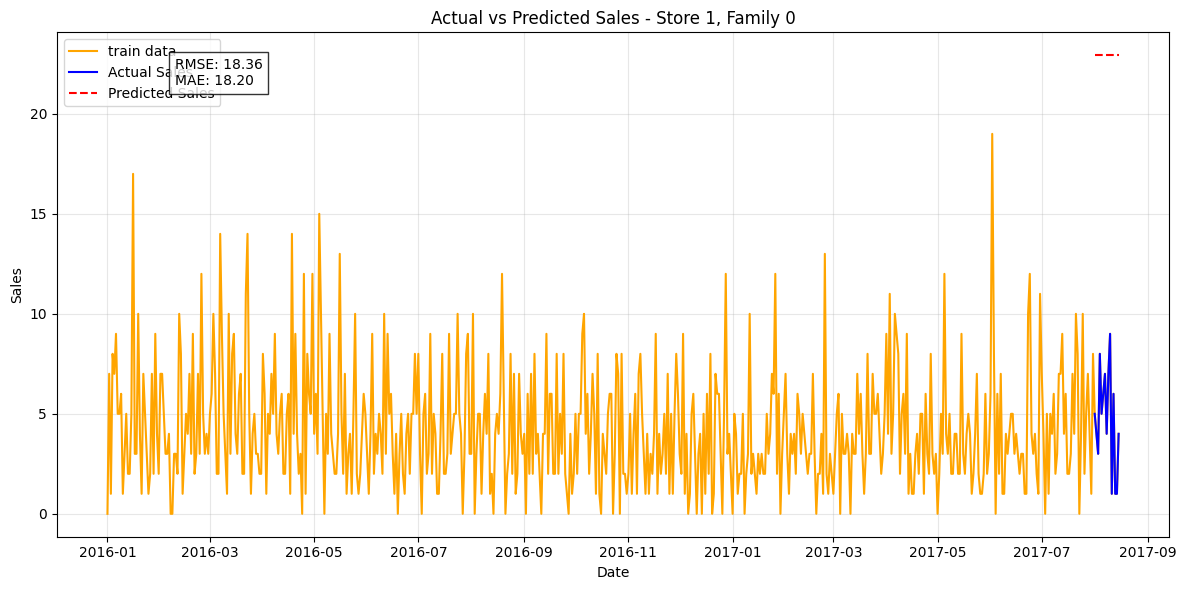

In [ ]:
import matplotlib.dates as mdates

# Select data for a specific store and family
store_to_plot = 1
family_to_plot = 0  # Using the encoded value of the family you want to plot
family_cat = 'AUTOMOTIVE'

filtered_results = results_df[(results_df['store_nbr'] == store_to_plot) & 
                             (results_df['family'] == family_to_plot)]

train_data = late_df[(late_df['store_nbr'] == store_to_plot) & 
                (late_df['family'] == family_cat)]

# Sort by date to ensure proper chronological order
filtered_results = filtered_results.sort_values('date')

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['sales'], color='orange', label='train data')
plt.plot(filtered_results['date'], filtered_results['actual'], 'b-', label='Actual Sales')
plt.plot(filtered_results['date'], filtered_results['predicted'], 'r--', label='Predicted Sales')

# Format the plot
plt.title(f'Actual vs Predicted Sales - Store {store_to_plot}, Family {family_to_plot}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)

mse = mean_squared_error(filtered_results['actual'], filtered_results['predicted'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(filtered_results['actual'], filtered_results['predicted'])

plt.figtext(0.15, 0.85, f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}', 
           bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

___

### improvement

In [57]:
df = pd.read_csv('train.csv')
holiday = pd.read_csv('holidays_events.csv')
nmdf = pd.merge(df, holiday, on='date', how='left')
nmdf['is_holiday'] = np.where(nmdf['type'].isna(), 0, 1)
nmdf = nmdf.drop(columns=['id', 'type', 'locale', 'locale_name', 'description', 'transferred'])
nmdf.set_index('date', inplace=True)
nmdf.index = pd.to_datetime(nmdf.index)
nmdf['day'] = nmdf.index.day # day of month
nmdf['month'] = nmdf.index.month
nmdf['day_of_week'] = nmdf.index.dayofweek
nmdf['day_of_year'] = nmdf.index.dayofyear
nmdf['rolling_mean_30'] = nmdf.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(30, min_periods=1).mean())
nmdf.head()

store_nbr      family  sales  onpromotion  is_holiday  day  month  \
date                                                                            
2013-01-01          1  AUTOMOTIVE    0.0            0           1    1      1   
2013-01-01          1   BABY CARE    0.0            0           1    1      1   
2013-01-01          1      BEAUTY    0.0            0           1    1      1   
2013-01-01          1   BEVERAGES    0.0            0           1    1      1   
2013-01-01          1       BOOKS    0.0            0           1    1      1   

            day_of_week  day_of_year  rolling_mean_30  
date                                                   
2013-01-01            1            1              0.0  
2013-01-01            1            1              0.0  
2013-01-01            1            1              0.0  
2013-01-01            1            1              0.0  
2013-01-01            1            1              0.0

In [58]:
nmdf = nmdf.sort_values(['store_nbr', 'family', 'date'])
for lag in [1, 2, 3, 7, 14, 28]:
    nmdf[f'sales_lag_{lag}'] = nmdf.groupby(['store_nbr', 'family'])['sales'].shift(lag)

nmdf.head()

store_nbr      family  sales  onpromotion  is_holiday  day  month  \
date                                                                            
2013-01-01          1  AUTOMOTIVE    0.0            0           1    1      1   
2013-01-02          1  AUTOMOTIVE    2.0            0           0    2      1   
2013-01-03          1  AUTOMOTIVE    3.0            0           0    3      1   
2013-01-04          1  AUTOMOTIVE    3.0            0           0    4      1   
2013-01-05          1  AUTOMOTIVE    5.0            0           1    5      1   

            day_of_week  day_of_year  rolling_mean_30  sales_lag_1  \
date                                                                 
2013-01-01            1            1         0.000000          NaN   
2013-01-02            2            2         1.000000          0.0   
2013-01-03            3            3         1.666667          2.0   
2013-01-04            4            4         2.000000          3.0   
2013-01-05            5            5         2.600000          3.0   

            sales_lag_2  sales_lag_3  sales_lag_7  sales_lag_14  sales_lag_28  
date                                                                           
2013-01-01          NaN          NaN          NaN           NaN           NaN  
2013-01-02          NaN          NaN          NaN           NaN           NaN  
2013-01-03          0.0          NaN          NaN           NaN           NaN  
2013-01-04          2.0          0.0          NaN           NaN           NaN  
2013-01-05          3.0          2.0          NaN           NaN           NaN

In [59]:
nlate_df = nmdf[nmdf.index.year >= 2016]
nlate_df

store_nbr      family  sales  onpromotion  is_holiday  day  month  \
date                                                                            
2016-01-01          1  AUTOMOTIVE    0.0            0           1    1      1   
2016-01-02          1  AUTOMOTIVE    7.0            0           0    2      1   
2016-01-03          1  AUTOMOTIVE    1.0            0           0    3      1   
2016-01-04          1  AUTOMOTIVE    8.0            0           0    4      1   
2016-01-05          1  AUTOMOTIVE    7.0            0           0    5      1   
...               ...         ...    ...          ...         ...  ...    ...   
2017-08-11         54     SEAFOOD    0.0            0           1   11      8   
2017-08-12         54     SEAFOOD    1.0            1           0   12      8   
2017-08-13         54     SEAFOOD    2.0            0           0   13      8   
2017-08-14         54     SEAFOOD    0.0            0           0   14      8   
2017-08-15         54     SEAFOOD    3.0            0           1   15      8   

            day_of_week  day_of_year  rolling_mean_30  sales_lag_1  \
date                                                                 
2016-01-01            4            1         4.500000          5.0   
2016-01-02            5            2         4.566667          0.0   
2016-01-03            6            3         4.400000          7.0   
2016-01-04            0            4         4.466667          1.0   
2016-01-05            1            5         4.700000          8.0   
...                 ...          ...              ...          ...   
2017-08-11            4          223         2.933333          2.0   
2017-08-12            5          224         2.966667          0.0   
2017-08-13            6          225         3.033333          1.0   
2017-08-14            0          226         2.966667          2.0   
2017-08-15            1          227         2.900000          0.0   

            sales_lag_2  sales_lag_3  sales_lag_7  sales_lag_14  sales_lag_28  
date                                                                           
2016-01-01          5.0          8.0          4.0           0.0           6.0  
2016-01-02          5.0          5.0          7.0           3.0           6.0  
2016-01-03          0.0          5.0          4.0           0.0           0.0  
2016-01-04          7.0          0.0          4.0           1.0           1.0  
2016-01-05          1.0          7.0          8.0           9.0           6.0  
...                 ...          ...          ...           ...           ...  
2017-08-11          4.0         12.0          0.0           4.0           0.0  
2017-08-12          2.0          4.0          3.0           4.0           2.0  
2017-08-13          0.0          2.0          0.0           4.0           5.0  
2017-08-14          1.0          0.0          0.0           4.0           3.0  
2017-08-15          2.0          1.0         12.0           3.0           6.0  

[1081674 rows x 16 columns]

In [ ]:
# convert these to category type and then some more features

nlate_df['store_nbr'] = nlate_df['store_nbr'].astype('category') 
nlate_df['family'] = nlate_df['family'].astype('category')


C:\Users\ahmed\AppData\Local\Temp\ipykernel_32584\1996444548.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ahmed\AppData\Local\Temp\ipykernel_32584\1996444548.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [62]:
# create day of the week mean sales column

mask = ~((nlate_df.index.month == 12) & (nlate_df.index.day >= 12) | 
             (nlate_df.index.month == 1) & (nlate_df.index.day <= 5)) # removing the cristmas time
filtered_df = nlate_df[mask] 

aggregated_df = filtered_df.groupby(['store_nbr', 'family', 'day_of_week'])['sales'].mean().reset_index() # getting the mean sales of these columns
aggregated_df.rename(columns={'sales': 'dow_mean_sales'}, inplace=True) # renaming the sales column to day of the week mean sales

new_df = pd.merge(nlate_df.reset_index(), aggregated_df, on=['store_nbr', 'family', 'day_of_week'], how='left') # merge it to the actual df as a new column
new_df


C:\Users\ahmed\AppData\Local\Temp\ipykernel_32584\1597583821.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



date store_nbr      family  sales  onpromotion  is_holiday  day  \
0       2016-01-01         1  AUTOMOTIVE    0.0            0           1    1   
1       2016-01-02         1  AUTOMOTIVE    7.0            0           0    2   
2       2016-01-03         1  AUTOMOTIVE    1.0            0           0    3   
3       2016-01-04         1  AUTOMOTIVE    8.0            0           0    4   
4       2016-01-05         1  AUTOMOTIVE    7.0            0           0    5   
...            ...       ...         ...    ...          ...         ...  ...   
1081669 2017-08-11        54     SEAFOOD    0.0            0           1   11   
1081670 2017-08-12        54     SEAFOOD    1.0            1           0   12   
1081671 2017-08-13        54     SEAFOOD    2.0            0           0   13   
1081672 2017-08-14        54     SEAFOOD    0.0            0           0   14   
1081673 2017-08-15        54     SEAFOOD    3.0            0           1   15   

         month  day_of_week  day_of_year  rolling_mean_30  sales_lag_1  \
0            1            4            1         4.500000          5.0   
1            1            5            2         4.566667          0.0   
2            1            6            3         4.400000          7.0   
3            1            0            4         4.466667          1.0   
4            1            1            5         4.700000          8.0   
...        ...          ...          ...              ...          ...   
1081669      8            4          223         2.933333          2.0   
1081670      8            5          224         2.966667          0.0   
1081671      8            6          225         3.033333          1.0   
1081672      8            0          226         2.966667          2.0   
1081673      8            1          227         2.900000          0.0   

         sales_lag_2  sales_lag_3  sales_lag_7  sales_lag_14  sales_lag_28  \
0                5.0          8.0          4.0           0.0           6.0   
1                5.0          5.0          7.0           3.0           6.0   
2                0.0          5.0          4.0           0.0           0.0   
3                7.0          0.0          4.0           1.0           1.0   
4                1.0          7.0          8.0           9.0           6.0   
...              ...          ...          ...           ...           ...   
1081669          4.0         12.0          0.0           4.0           0.0   
1081670          2.0          4.0          3.0           4.0           2.0   
1081671          0.0          2.0          0.0           4.0           5.0   
1081672          1.0          0.0          0.0           4.0           3.0   
1081673          2.0          1.0         12.0           3.0           6.0   

         dow_mean_sales  
0              4.987805  
1              4.941176  
2              2.241379  
3              4.358025  
4              4.612500  
...                 ...  
1081669        1.012195  
1081670        1.823529  
1081671        2.356322  
1081672        2.012346  
1081673        2.000000  

[1081674 rows x 18 columns]

In [63]:
index_backup = nlate_df.index  # save index
new_df.set_index(index_backup, inplace=True)


In [64]:
# is_month_end, is_month_start, is

new_df['is_month_end'] = new_df.index.is_month_end
new_df['is_month_start'] = new_df.index.is_month_start
new_df['is_quarter_end'] = new_df.index.is_quarter_end
new_df['is_quarter_start'] = new_df.index.is_quarter_start

new_df

date store_nbr      family  sales  onpromotion  is_holiday  \
date                                                                          
2016-01-01 2016-01-01         1  AUTOMOTIVE    0.0            0           1   
2016-01-02 2016-01-02         1  AUTOMOTIVE    7.0            0           0   
2016-01-03 2016-01-03         1  AUTOMOTIVE    1.0            0           0   
2016-01-04 2016-01-04         1  AUTOMOTIVE    8.0            0           0   
2016-01-05 2016-01-05         1  AUTOMOTIVE    7.0            0           0   
...               ...       ...         ...    ...          ...         ...   
2017-08-11 2017-08-11        54     SEAFOOD    0.0            0           1   
2017-08-12 2017-08-12        54     SEAFOOD    1.0            1           0   
2017-08-13 2017-08-13        54     SEAFOOD    2.0            0           0   
2017-08-14 2017-08-14        54     SEAFOOD    0.0            0           0   
2017-08-15 2017-08-15        54     SEAFOOD    3.0            0           1   

            day  month  day_of_week  day_of_year  ...  sales_lag_2  \
date                                              ...                
2016-01-01    1      1            4            1  ...          5.0   
2016-01-02    2      1            5            2  ...          5.0   
2016-01-03    3      1            6            3  ...          0.0   
2016-01-04    4      1            0            4  ...          7.0   
2016-01-05    5      1            1            5  ...          1.0   
...         ...    ...          ...          ...  ...          ...   
2017-08-11   11      8            4          223  ...          4.0   
2017-08-12   12      8            5          224  ...          2.0   
2017-08-13   13      8            6          225  ...          0.0   
2017-08-14   14      8            0          226  ...          1.0   
2017-08-15   15      8            1          227  ...          2.0   

            sales_lag_3  sales_lag_7  sales_lag_14  sales_lag_28  \
date                                                               
2016-01-01          8.0          4.0           0.0           6.0   
2016-01-02          5.0          7.0           3.0           6.0   
2016-01-03          5.0          4.0           0.0           0.0   
2016-01-04          0.0          4.0           1.0           1.0   
2016-01-05          7.0          8.0           9.0           6.0   
...                 ...          ...           ...           ...   
2017-08-11         12.0          0.0           4.0           0.0   
2017-08-12          4.0          3.0           4.0           2.0   
2017-08-13          2.0          0.0           4.0           5.0   
2017-08-14          0.0          0.0           4.0           3.0   
2017-08-15          1.0         12.0           3.0           6.0   

            dow_mean_sales  is_month_end  is_month_start  is_quarter_end  \
date                                                                       
2016-01-01        4.987805         False            True           False   
2016-01-02        4.941176         False           False           False   
2016-01-03        2.241379         False           False           False   
2016-01-04        4.358025         False           False           False   
2016-01-05        4.612500         False           False           False   
...                    ...           ...             ...             ...   
2017-08-11        1.012195         False           False           False   
2017-08-12        1.823529         False           False           False   
2017-08-13        2.356322         False           False           False   
2017-08-14        2.012346         False           False           False   
2017-08-15        2.000000         False           False           False   

            is_quarter_start  
date                          
2016-01-01              True  
2016-01-02             False  
2016-01-03             False  
2016-01-04             False  
2016-01-05        

In [65]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1081674 entries, 2016-01-01 to 2017-08-15
Data columns (total 22 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   date              1081674 non-null  datetime64[ns]
 1   store_nbr         1081674 non-null  category      
 2   family            1081674 non-null  category      
 3   sales             1081674 non-null  float64       
 4   onpromotion       1081674 non-null  int64         
 5   is_holiday        1081674 non-null  int64         
 6   day               1081674 non-null  int32         
 7   month             1081674 non-null  int32         
 8   day_of_week       1081674 non-null  int32         
 9   day_of_year       1081674 non-null  int32         
 10  rolling_mean_30   1081674 non-null  float64       
 11  sales_lag_1       1081674 non-null  float64       
 12  sales_lag_2       1081674 non-null  float64       
 13  sales_lag_3       1081674 n

In [66]:
# new_df = new_df.drop(['date'], axis=1, inplace=True)

new_df = new_df.drop(columns= ['date'])

In [67]:
X = new_df.drop(columns = ['sales'])
y = new_df['sales']

split_date = '2017-08-01'
X_train, X_test = X[X.index < split_date], X[X.index >= split_date]
y_train, y_test = y[y.index < split_date], y[y.index >= split_date]

In [68]:
le = LabelEncoder()
X_train['family'] = le.fit_transform(X_train['family'])
X_test['family'] = le.transform(X_test['family'])

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'seed': 555,
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,            # Max number of boosting iterations
    valid_sets=[test_data],          # Validation data
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # Stop if no improvement for 50 rounds
        lgb.log_evaluation(50)       # Print metrics every 50 rounds
    ]
)

C:\Users\ahmed\AppData\Local\Temp\ipykernel_32584\778978048.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ahmed\AppData\Local\Temp\ipykernel_32584\778978048.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 1054944, number of used features: 20
[LightGBM] [Info] Start training from score 6.130284
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 375.432
[100]	valid_0's rmse: 227.624
[150]	valid_0's rmse: 221.988
[200]	valid_0's rmse: 219.683
[250]	valid_0's rmse: 214.409
[300]	valid_0's rmse: 213.381
[350]	valid_0's rmse: 210.653
[400]	valid_0's rmse: 205.532
[450]	valid_0's rmse: 202.83
[500]	valid_0's rmse: 200.07
[550]	valid_0's rmse: 199.104
[600]	valid_0's rmse: 198.417
[650]	valid_0's rmse: 196.911
[700]	valid_0's rmse: 195.707
[750]	valid_0's rmse: 195.084
[800]	valid_0's rmse: 194.24
[850]	valid_0's rmse: 193.535
[900]	valid_0's rmse: 192.779
[950]	valid_0's rmse: 191.836
[1000]	valid_0's rmse: 191.19

In [69]:
y_pred = model.predict(X_test)

results_df = pd.DataFrame()

results_df['date'] = X_test.index
results_df['store_nbr'] = X_test['store_nbr'].reset_index(drop=True)
results_df['family'] = X_test['family'].reset_index(drop=True)
results_df['actual'] = y_test.reset_index(drop=True)
results_df['predicted'] = y_pred 

results_df

date store_nbr  family  actual  predicted
0     2017-08-01         1       0     5.0   5.276228
1     2017-08-02         1       0     4.0   5.042794
2     2017-08-03         1       0     3.0   4.671875
3     2017-08-04         1       0     8.0   5.066668
4     2017-08-05         1       0     5.0   5.491862
...          ...       ...     ...     ...        ...
26725 2017-08-11        54      32     0.0   2.072760
26726 2017-08-12        54      32     1.0   2.977298
26727 2017-08-13        54      32     2.0   2.419273
26728 2017-08-14        54      32     0.0   2.058087
26729 2017-08-15        54      32     3.0   2.006477

[26730 rows x 5 columns]

In [70]:
mse = mean_squared_error(results_df['actual'], results_df['predicted'])
mae = mean_absolute_error(results_df['actual'], results_df['predicted'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(results_df['actual'], results_df['predicted'])

print(f'mae is: {mae}')
print(f'rmse is {rmse}')
print(f'mape is {mape}')

mae is: 54.952299546345834
rmse is 191.1873684215143
mape is 295627426740132.44


In [71]:
from sklearn.metrics import mean_squared_log_error

msle = mean_squared_log_error(results_df['actual'], results_df['predicted'])

rmsle = np.sqrt(msle)

print(f'the RMSLE is {rmsle}')

the RMSLE is 0.3762104823544787


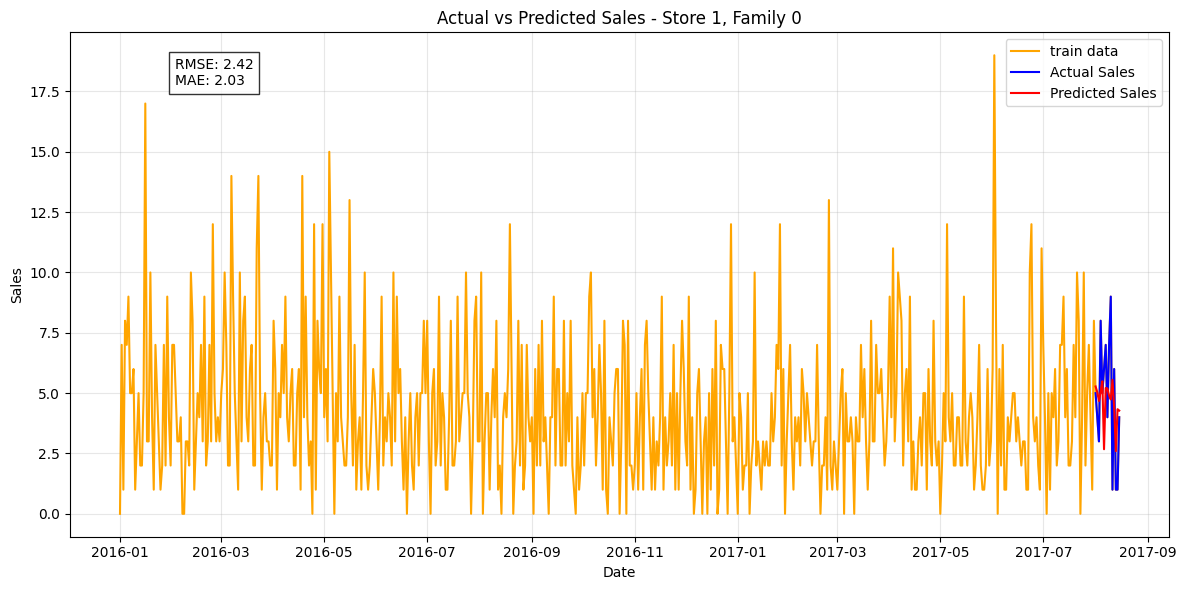

In [ ]:
import matplotlib.dates as mdates

# Select data for a specific store and family
store_to_plot = 1
family_to_plot = 0  # Using the encoded value of the family you want to plot
family_cat = 'AUTOMOTIVE'

filtered_results = results_df[(results_df['store_nbr'] == store_to_plot) & 
                             (results_df['family'] == family_to_plot)]

train_data = nlate_df[(nlate_df['store_nbr'] == store_to_plot) & 
                (nlate_df['family'] == family_cat)]

# Sort by date to ensure proper chronological order
filtered_results = filtered_results.sort_values('date')

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['sales'], color='orange', label='train data')
plt.plot(filtered_results['date'], filtered_results['actual'], color = 'blue', label='Actual Sales')
plt.plot(filtered_results['date'], filtered_results['predicted'], color = 'red', label='Predicted Sales')

# Format the plot
plt.title(f'Actual vs Predicted Sales - Store {store_to_plot}, Family {family_to_plot}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)

mse = mean_squared_error(filtered_results['actual'], filtered_results['predicted'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(filtered_results['actual'], filtered_results['predicted'])

plt.figtext(0.15, 0.85, f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}', 
           bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [73]:
importance_split = model.feature_importance(importance_type='split')
importance_gain = model.feature_importance(importance_type='gain')

# Create a DataFrame
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance_split': importance_split,
    'importance_gain': importance_gain
})


feature_importance = feature_importance.sort_values('importance_gain', ascending=False)

print(feature_importance)

             feature  importance_split  importance_gain
8    rolling_mean_30              2140     6.161865e+08
15    dow_mean_sales              2168     1.332157e+08
9        sales_lag_1              1993     8.872129e+06
12       sales_lag_7              1230     7.203933e+06
7        day_of_year              3879     2.149822e+06
0          store_nbr              6137     1.589466e+06
4                day              2148     8.664927e+05
2        onpromotion              1403     7.966958e+05
6        day_of_week              1765     5.617951e+05
13      sales_lag_14               796     4.347378e+05
10       sales_lag_2               946     3.149252e+05
5              month               830     3.059912e+05
14      sales_lag_28              1089     3.035533e+05
1             family              1737     2.308625e+05
3         is_holiday               556     1.926724e+05
11       sales_lag_3               734     1.745151e+05
17    is_month_start                58     6.487

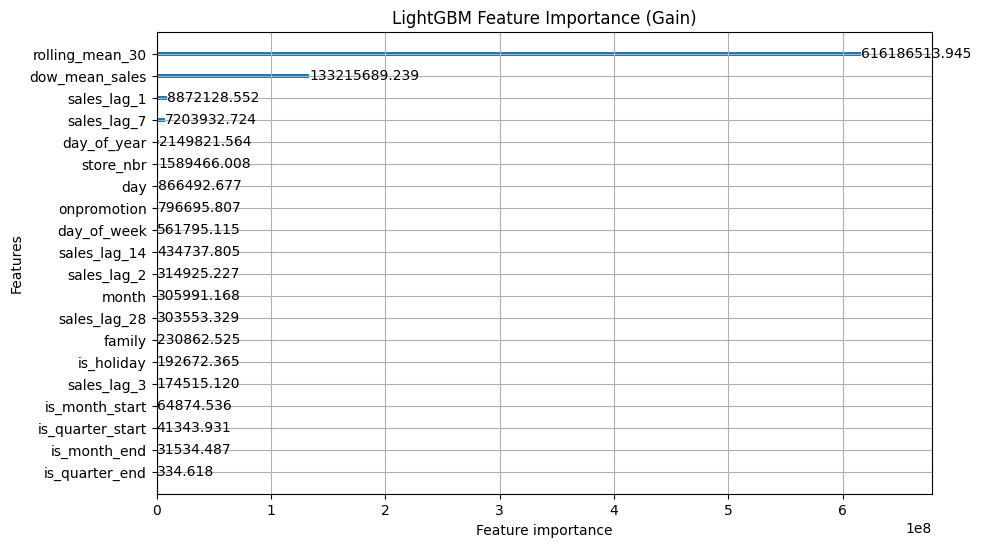

In [74]:
lgb.plot_importance(model, importance_type='gain', figsize=(10, 6))
plt.title("LightGBM Feature Importance (Gain)")
plt.show()

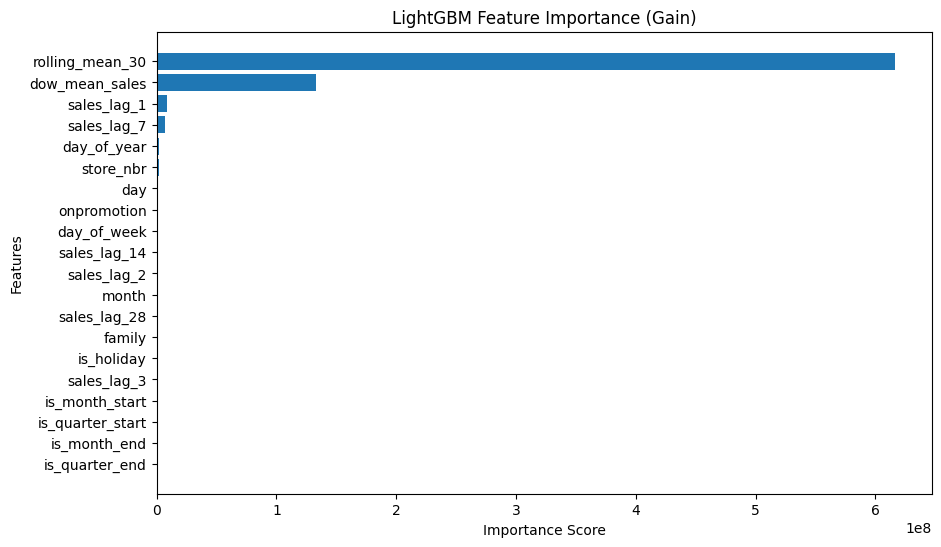

In [75]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance_gain'])
plt.title("LightGBM Feature Importance (Gain)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

In [76]:
new_df

store_nbr      family  sales  onpromotion  is_holiday  day  month  \
date                                                                           
2016-01-01         1  AUTOMOTIVE    0.0            0           1    1      1   
2016-01-02         1  AUTOMOTIVE    7.0            0           0    2      1   
2016-01-03         1  AUTOMOTIVE    1.0            0           0    3      1   
2016-01-04         1  AUTOMOTIVE    8.0            0           0    4      1   
2016-01-05         1  AUTOMOTIVE    7.0            0           0    5      1   
...              ...         ...    ...          ...         ...  ...    ...   
2017-08-11        54     SEAFOOD    0.0            0           1   11      8   
2017-08-12        54     SEAFOOD    1.0            1           0   12      8   
2017-08-13        54     SEAFOOD    2.0            0           0   13      8   
2017-08-14        54     SEAFOOD    0.0            0           0   14      8   
2017-08-15        54     SEAFOOD    3.0            0           1   15      8   

            day_of_week  day_of_year  rolling_mean_30  ...  sales_lag_2  \
date                                                   ...                
2016-01-01            4            1         4.500000  ...          5.0   
2016-01-02            5            2         4.566667  ...          5.0   
2016-01-03            6            3         4.400000  ...          0.0   
2016-01-04            0            4         4.466667  ...          7.0   
2016-01-05            1            5         4.700000  ...          1.0   
...                 ...          ...              ...  ...          ...   
2017-08-11            4          223         2.933333  ...          4.0   
2017-08-12            5          224         2.966667  ...          2.0   
2017-08-13            6          225         3.033333  ...          0.0   
2017-08-14            0          226         2.966667  ...          1.0   
2017-08-15            1          227         2.900000  ...          2.0   

            sales_lag_3  sales_lag_7  sales_lag_14  sales_lag_28  \
date                                                               
2016-01-01          8.0          4.0           0.0           6.0   
2016-01-02          5.0          7.0           3.0           6.0   
2016-01-03          5.0          4.0           0.0           0.0   
2016-01-04          0.0          4.0           1.0           1.0   
2016-01-05          7.0          8.0           9.0           6.0   
...                 ...          ...           ...           ...   
2017-08-11         12.0          0.0           4.0           0.0   
2017-08-12          4.0          3.0           4.0           2.0   
2017-08-13          2.0          0.0           4.0           5.0   
2017-08-14          0.0          0.0           4.0           3.0   
2017-08-15          1.0         12.0           3.0           6.0   

            dow_mean_sales  is_month_end  is_month_start  is_quarter_end  \
date                                                                       
2016-01-01        4.987805         False            True           False   
2016-01-02        4.941176         False           False           False   
2016-01-03        2.241379         False           False           False   
2016-01-04        4.358025         False           False           False   
2016-01-05        4.612500         False           False           False   
...                    ...           ...             ...             ...   
2017-08-11        1.012195         False           False           False   
2017-08-12        1.823529         False           False           False   
2017-08-13        2.356322         False           False           False   
2017-08-14        2.012346         False           False           False   
2017-08-15        2.000000         False           False           False   

            is_quarter_start  
date                          
2016-01-01              True  
2016-01-02             Fals

In [77]:
new_df.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'is_holiday', 'day',
       'month', 'day_of_week', 'day_of_year', 'rolling_mean_30', 'sales_lag_1',
       'sales_lag_2', 'sales_lag_3', 'sales_lag_7', 'sales_lag_14',
       'sales_lag_28', 'dow_mean_sales', 'is_month_end', 'is_month_start',
       'is_quarter_end', 'is_quarter_start'],
      dtype='object')

In [78]:
kopy = new_df.copy()

In [79]:
test = pd.read_csv('forecast.csv')
test.head()

Unnamed: 0       id        date  store_nbr      family  onpromotion  \
0           0  3000888  16/08/2017          1  AUTOMOTIVE            0   
1           1  3000889  16/08/2017          1   BABY CARE            0   
2           2  3000890  16/08/2017          1      BEAUTY            2   
3           3  3000891  16/08/2017          1   BEVERAGES           20   
4           4  3000892  16/08/2017          1       BOOKS            0   

   is_holiday  
0           0  
1           0  
2           0  
3           0  
4           0

In [80]:
test = test.drop(columns=['Unnamed: 0', 'id'])
test.head()

date  store_nbr      family  onpromotion  is_holiday
0  16/08/2017          1  AUTOMOTIVE            0           0
1  16/08/2017          1   BABY CARE            0           0
2  16/08/2017          1      BEAUTY            2           0
3  16/08/2017          1   BEVERAGES           20           0
4  16/08/2017          1       BOOKS            0           0

In [81]:
test = test.set_index('date')

In [82]:
test.head()

store_nbr      family  onpromotion  is_holiday
date                                                      
16/08/2017          1  AUTOMOTIVE            0           0
16/08/2017          1   BABY CARE            0           0
16/08/2017          1      BEAUTY            2           0
16/08/2017          1   BEVERAGES           20           0
16/08/2017          1       BOOKS            0           0

In [83]:
kopy = pd.concat([kopy, test])
kopy.tail()

store_nbr                      family  sales  onpromotion  \
date                                                                    
31/08/2017          9                     POULTRY    NaN            1   
31/08/2017          9              PREPARED FOODS    NaN            0   
31/08/2017          9                     PRODUCE    NaN            1   
31/08/2017          9  SCHOOL AND OFFICE SUPPLIES    NaN            9   
31/08/2017          9                     SEAFOOD    NaN            0   

            is_holiday  day  month  day_of_week  day_of_year  rolling_mean_30  \
date                                                                            
31/08/2017           0  NaN    NaN          NaN          NaN              NaN   
31/08/2017           0  NaN    NaN          NaN          NaN              NaN   
31/08/2017           0  NaN    NaN          NaN          NaN              NaN   
31/08/2017           0  NaN    NaN          NaN          NaN              NaN   
31/08/2017           0  NaN    NaN          NaN          NaN              NaN   

            ...  sales_lag_2  sales_lag_3  sales_lag_7  sales_lag_14  \
date        ...                                                        
31/08/2017  ...          NaN          NaN          NaN           NaN   
31/08/2017  ...          NaN          NaN          NaN           NaN   
31/08/2017  ...          NaN          NaN          NaN           NaN   
31/08/2017  ...          NaN          NaN          NaN           NaN   
31/08/2017  ...          NaN          NaN          NaN           NaN   

            sales_lag_28  dow_mean_sales  is_month_end is_month_start  \
date                                                                    
31/08/2017           NaN             NaN           NaN            NaN   
31/08/2017           NaN             NaN           NaN            NaN   
31/08/2017           NaN             NaN           NaN            NaN   
31/08/2017           NaN             NaN           NaN            NaN   
31/08/2017           NaN             NaN           NaN            NaN   

           is_quarter_end is_quarter_start  
date                                        
31/08/2017            NaN              NaN  
31/08/2017            NaN              NaN  
31/08/2017            NaN              NaN  
31/08/2017            NaN              NaN  
31/08/2017            NaN              NaN  

[5 rows x 21 columns]

In [84]:
kopy.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'is_holiday', 'day',
       'month', 'day_of_week', 'day_of_year', 'rolling_mean_30', 'sales_lag_1',
       'sales_lag_2', 'sales_lag_3', 'sales_lag_7', 'sales_lag_14',
       'sales_lag_28', 'dow_mean_sales', 'is_month_end', 'is_month_start',
       'is_quarter_end', 'is_quarter_start'],
      dtype='object')

In [86]:
kopy.index = pd.to_datetime(kopy.index)


In [96]:
test_start = pd.to_datetime('2017-08-16')

kopy['family'] = kopy['family'].astype('category')
kopy['store_nbr'] = kopy['store_nbr'].astype('category')

In [97]:
# First create all features based on known data
kopy['family'] = le.fit_transform(kopy['family'])
kopy['day'] = kopy.index.day
kopy['month'] = kopy.index.month
kopy['day_of_week'] = kopy.index.dayofweek  # Using correct attribute name
kopy['day_of_year'] = kopy.index.dayofyear  # Using correct attribute name
kopy['rolling_mean_30'] = kopy.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(30, min_periods=1).mean())
kopy['sales_lag_1'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(1)
kopy['sales_lag_2'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(2)
kopy['sales_lag_3'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(3)
kopy['sales_lag_7'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(7)
kopy['sales_lag_14'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(14)
kopy['sales_lag_28'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(28)
kopy['dow_mean_sales'] = kopy.groupby(['store_nbr', 'family', 'day_of_week'])['sales'].transform('mean')
kopy['is_month_end'] = kopy.index.is_month_end
kopy['is_month_start'] = kopy.index.is_month_start
kopy['is_quarter_end'] = kopy.index.is_quarter_end
kopy['is_quarter_start'] = kopy.index.is_quarter_start

# Get test data in chronological order
test_data = kopy[kopy.index >= test_start].copy().sort_index()

# Create a copy of sales for the test period (this will be updated with predictions)
test_data['predicted_sales'] = np.nan

# Iterate through the test set day by day
for date in sorted(test_data.index.unique()):
    # Get data for the current date
    current_day_data = test_data[test_data.index == date].copy()
    
    # Prepare features
    X_day = current_day_data.drop(['sales', 'predicted_sales'], axis=1)
    
    # Make predictions for this day
    y_pred = model.predict(X_day)
    
    # Store predictions
    test_data.loc[test_data.index == date, 'predicted_sales'] = y_pred
    
    # Update the sales column with predictions for lag calculation in next iteration
    kopy.loc[kopy.index == date, 'sales'] = y_pred

# Display results
print(test_data[['sales', 'predicted_sales']].head())

C:\Users\ahmed\AppData\Local\Temp\ipykernel_32584\3295697511.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\ahmed\AppData\Local\Temp\ipykernel_32584\3295697511.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\ahmed\AppData\Local\Temp\ipykernel_32584\3295697511.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\ahmed\AppData\Local\Temp\ipykernel_32584\3295697511.py:10: FutureWarning:

T

            sales  predicted_sales
date                              
2017-08-16    NaN     4.668480e+00
2017-08-16    NaN     3.840701e-09
2017-08-16    NaN     4.863100e+00
2017-08-16    NaN     2.377726e+03
2017-08-16    NaN     1.087566e-01


In [98]:
kopy

store_nbr  family      sales  onpromotion  is_holiday  day  month  \
date                                                                           
2016-01-01         1       0   0.000000            0           1    1      1   
2016-01-02         1       0   7.000000            0           0    2      1   
2016-01-03         1       0   1.000000            0           0    3      1   
2016-01-04         1       0   8.000000            0           0    4      1   
2016-01-05         1       0   7.000000            0           0    5      1   
...              ...     ...        ...          ...         ...  ...    ...   
2017-08-31         9      28   6.716931            1           0   31      8   
2017-08-31         9      29   1.094486            0           0   31      8   
2017-08-31         9      30  13.536352            1           0   31      8   
2017-08-31         9      31   4.657162            9           0   31      8   
2017-08-31         9      32   1.085870            0           0   31      8   

            day_of_week  day_of_year  rolling_mean_30  ...  sales_lag_2  \
date                                                   ...                
2016-01-01            4            1         0.000000  ...          NaN   
2016-01-02            5            2         3.500000  ...          NaN   
2016-01-03            6            3         2.666667  ...          0.0   
2016-01-04            0            4         4.000000  ...          7.0   
2016-01-05            1            5         4.600000  ...          1.0   
...                 ...          ...              ...  ...          ...   
2017-08-31            3          243       437.880281  ...          NaN   
2017-08-31            3          243       120.867428  ...          NaN   
2017-08-31            3          243      1606.105500  ...          NaN   
2017-08-31            3          243       150.071429  ...          NaN   
2017-08-31            3          243        19.001929  ...          NaN   

            sales_lag_3  sales_lag_7  sales_lag_14  sales_lag_28  \
date                                                               
2016-01-01          NaN          NaN           NaN           NaN   
2016-01-02          NaN          NaN           NaN           NaN   
2016-01-03          NaN          NaN           NaN           NaN   
2016-01-04          0.0          NaN           NaN           NaN   
2016-01-05          7.0          NaN           NaN           NaN   
...                 ...          ...           ...           ...   
2017-08-31          NaN          NaN           NaN       425.946   
2017-08-31          NaN          NaN           NaN        83.426   
2017-08-31          NaN          NaN           NaN      1364.578   
2017-08-31          NaN          NaN           NaN       139.000   
2017-08-31          NaN          NaN           NaN        21.778   

            dow_mean_sales  is_month_end  is_month_start  is_quarter_end  \
date                                                                       
2016-01-01        4.883721         False            True           False   
2016-01-02        4.955056         False           False           False   
2016-01-03        2.200000         False           False           False   
2016-01-04        4.383721         False           False           False   
2016-01-05        4.576471         False           False           False   
...                    ...           ...             ...             ...   
2017-08-31      356.196747          True           False           False   
2017-08-31       98.578586          True           False           False   
2017-08-31     1233.566379          True           False           False   
2017-08-31        8.218391          True           False           False   
2017-08-31       13.549713          True           False           False   

            is_quarter_start  
date                          
2016-01-01              True  
2016-01-02             Fals

In [95]:
# Print the features and their data types
print("X_day features:")
print(X_day.dtypes)

# Show the first few rows for inspection
print("\nFirst 5 rows of X_day:")
print(X_day.head())

# Check categorical features specifically
categorical_columns = X_day.select_dtypes(include=['category']).columns
print("\nCategorical columns:", categorical_columns.tolist())

if len(categorical_columns) > 0:
    for col in categorical_columns:
        print(f"\nCategories in {col}:", list(X_day[col].cat.categories))

X_day features:
store_nbr             int64
family                int64
onpromotion           int64
is_holiday            int64
day                   int32
month                 int32
day_of_week           int32
day_of_year           int32
rolling_mean_30     float64
sales_lag_1         float64
sales_lag_2         float64
sales_lag_3         float64
sales_lag_7         float64
sales_lag_14        float64
sales_lag_28        float64
dow_mean_sales      float64
is_month_end           bool
is_month_start         bool
is_quarter_end         bool
is_quarter_start       bool
dtype: object

First 5 rows of X_day:
            store_nbr  family  onpromotion  is_holiday  day  month  \
date                                                                 
2017-08-16          1       0            0           0   16      8   
2017-08-16          1       1            0           0   16      8   
2017-08-16          1       2            2           0   16      8   
2017-08-16          1       3       

In [ ]:
le = LabelEncoder()

test_start = '16/08/17'

X = pd.DataFrame({})

for i in range(len(kopy)):
    if kopy[i].index < test_start:
        continue
    else:
        kopy['family'] = le.fit_transform(kopy['family'])
        kopy['day'] = kopy.index.day
        kopy['month'] = kopy.index.month
        kopy['day_of_week'] = kopy.index.day_of_week
        kopy['day_of_year'] = kopy.index.day_of_year
        kopy['rolling_mean_30'] = kopy.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(30, min_periods=1).mean())
        kopy['sales_lag_1'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(1)
        kopy['sales_lag_2'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(2)
        kopy['sales_lag_3'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(3)
        kopy['sales_lag_7'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(7)
        kopy['sales_lag_14'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(14)
        kopy['sales_lag_28'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(28)
        kopy['dow_mean_sales'] = kopy.groupby(['store_nbr', 'family', 'day_of_week'])['sales'].mean().reset_index()
        kopy['is_month_end'] = kopy.index.is_month_end
        kopy['is_month_start'] = kopy.index.is_month_start
        kopy['is_quarter_end'] = kopy.index.is_quarter_end
        kopy['is_quarter_start'] = kopy.index.is_quarter_start

        X = kopy[i].drop(['sales'])
        kopy['sales'] = model.predict(X)

        print(kopy[i])
        break

KeyError: 0

In [ ]:
# kopy['store_nbr'] = kopy['store_nbr'].astype('category')
# kopy['family'] = kopy['family'].astype('category')

# le = LabelEncoder()
# test_start = '16/08/17'

# kopy.index = pd.to_datetime(kopy.index)

# # First, prepare your features outside the loop
# kopy['family'] = le.fit_transform(kopy['family'])  # Fit transform once before looping
# kopy['day'] = kopy.index.day
# kopy['month'] = kopy.index.month
# kopy['day_of_week'] = kopy.index.day_of_week
# kopy['day_of_year'] = kopy.index.day_of_year
# kopy['rolling_mean_30'] = kopy.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(30, min_periods=1).mean())
# kopy['sales_lag_1'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(1)
# kopy['sales_lag_2'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(2)
# kopy['sales_lag_3'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(3)
# kopy['sales_lag_7'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(7)
# kopy['sales_lag_14'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(14)
# kopy['sales_lag_28'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(28)
# kopy['is_month_end'] = kopy.index.is_month_end
# kopy['is_month_start'] = kopy.index.is_month_start
# kopy['is_quarter_end'] = kopy.index.is_quarter_end
# kopy['is_quarter_start'] = kopy.index.is_quarter_start

# # Filter data for test period
# test_data = kopy[kopy.index >= test_start].copy()

# # Prepare features for prediction
# X = test_data.drop('sales', axis=1)

# # Make predictions
# test_data['predicted_sales'] = model.predict(X)

# # Display the first few rows of results
# print(test_data.head())

C:\Users\ahmed\AppData\Local\Temp\ipykernel_38812\2348856709.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kopy['rolling_mean_30'] = kopy.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(30, min_periods=1).mean())
C:\Users\ahmed\AppData\Local\Temp\ipykernel_38812\2348856709.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kopy['sales_lag_1'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(1)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_38812\2348856709.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

           store_nbr  family  sales  onpromotion  is_holiday  day  month  \
date                                                                       
2017-08-16         1       0    NaN            0           0   16      8   
2017-08-16         1       1    NaN            0           0   16      8   
2017-08-16         1       2    NaN            2           0   16      8   
2017-08-16         1       3    NaN           20           0   16      8   
2017-08-16         1       4    NaN            0           0   16      8   

            day_of_week  day_of_year  rolling_mean_30  ...  sales_lag_3  \
date                                                   ...                
2017-08-16            2          228         4.965517  ...          1.0   
2017-08-16            2          228         0.000000  ...          0.0   
2017-08-16            2          228         3.310345  ...          1.0   
2017-08-16            2          228      2060.068966  ...        803.0   
2017-08-16       

In [ ]:
# First create all features based on known data
kopy['family'] = le.fit_transform(kopy['family'])
kopy['day'] = kopy.index.day
kopy['month'] = kopy.index.month
kopy['day_of_week'] = kopy.index.dayofweek  # Using correct attribute name
kopy['day_of_year'] = kopy.index.dayofyear  # Using correct attribute name
kopy['rolling_mean_30'] = kopy.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(30, min_periods=1).mean())
kopy['sales_lag_1'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(1)
kopy['sales_lag_2'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(2)
kopy['sales_lag_3'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(3)
kopy['sales_lag_7'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(7)
kopy['sales_lag_14'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(14)
kopy['sales_lag_28'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(28)
kopy['is_month_end'] = kopy.index.is_month_end
kopy['is_month_start'] = kopy.index.is_month_start
kopy['is_quarter_end'] = kopy.index.is_quarter_end
kopy['is_quarter_start'] = kopy.index.is_quarter_start

# Get test data in chronological order
test_data = kopy[kopy.index >= test_start].copy().sort_index()

# Create a copy of sales for the test period (this will be updated with predictions)
test_data['predicted_sales'] = np.nan

# Iterate through the test set day by day
for date in sorted(test_data.index.unique()):
    # Get data for the current date
    current_day_data = test_data[test_data.index == date].copy()
    
    # Prepare features
    X_day = current_day_data.drop(['sales', 'predicted_sales'], axis=1)
    
    # Make predictions for this day
    y_pred = model.predict(X_day)
    
    # Store predictions
    test_data.loc[test_data.index == date, 'predicted_sales'] = y_pred
    
    # Update the sales column with predictions for lag calculation in next iteration
    kopy.loc[kopy.index == date, 'sales'] = y_pred

# Display results
print(test_data[['sales', 'predicted_sales']].head())

C:\Users\ahmed\AppData\Local\Temp\ipykernel_38812\2179017585.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kopy['rolling_mean_30'] = kopy.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(30, min_periods=1).mean())
C:\Users\ahmed\AppData\Local\Temp\ipykernel_38812\2179017585.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kopy['sales_lag_1'] = kopy.groupby(['store_nbr', 'family'])['sales'].shift(1)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_38812\2179017585.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

            sales  predicted_sales
date                              
2017-08-16    NaN     7.041733e-02
2017-08-16    NaN     3.840701e-09
2017-08-16    NaN     1.265881e-01
2017-08-16    NaN     1.201470e+01
2017-08-16    NaN     1.644824e-03


In [ ]:
kopy.tail()

store_nbr  family     sales  onpromotion  is_holiday  day  month  \
date                                                                          
2017-08-31         9      28  0.064508            1           0   31      8   
2017-08-31         9      29  0.012984            0           0   31      8   
2017-08-31         9      30  0.071345            1           0   31      8   
2017-08-31         9      31  0.071802            9           0   31      8   
2017-08-31         9      32  0.011867            0           0   31      8   

            day_of_week  day_of_year  rolling_mean_30  ...  sales_lag_2  \
date                                                   ...                
2017-08-31            3          243       437.880281  ...          NaN   
2017-08-31            3          243       120.867428  ...          NaN   
2017-08-31            3          243      1606.105500  ...          NaN   
2017-08-31            3          243       150.071429  ...          NaN   
2017-08-31            3          243        19.001929  ...          NaN   

            sales_lag_3  sales_lag_7  sales_lag_14  sales_lag_28  \
date                                                               
2017-08-31          NaN          NaN           NaN       425.946   
2017-08-31          NaN          NaN           NaN        83.426   
2017-08-31          NaN          NaN           NaN      1364.578   
2017-08-31          NaN          NaN           NaN       139.000   
2017-08-31          NaN          NaN           NaN        21.778   

            dow_mean_sales  is_month_end  is_month_start  is_quarter_end  \
date                                                                       
2017-08-31             NaN          True           False           False   
2017-08-31             NaN          True           False           False   
2017-08-31             NaN          True           False           False   
2017-08-31             NaN          True           False           False   
2017-08-31             NaN          True           False           False   

            is_quarter_start  
date                          
2017-08-31             False  
2017-08-31             False  
2017-08-31             False  
2017-08-31             False  
2017-08-31             False  

[5 rows x 21 columns]